## I. Introduction to the Problem and Dataset

In [501]:
print("Hello World!")

Hello World!


## II. Description of the dataset

## III. List of requirements

In [502]:
# Constants
dataset_path = 'Dataset 2 - Garments Dataset/garments.csv'
random_seed = 69

In [503]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

# Training and Testing the model
from sklearn.model_selection import train_test_split # For splitting the dataset into training and testing
from sklearn.pipeline import Pipeline # For creating a pipeline
from sklearn.compose import ColumnTransformer # For transforming the columns
from sklearn.preprocessing import StandardScaler # For Standardization
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV # For Hyperparameter Tuning
from sklearn.preprocessing import PolynomialFeatures  # For Polynomial Regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score   # For evaluation
import joblib   # For saving the model
from sklearn.base import BaseEstimator, RegressorMixin # For creating a custom regressor

# Models
from sklearn.linear_model import LinearRegression # For Linear Regression
from sklearn.neural_network import MLPRegressor # For Neural Network
from sklearn.ensemble import RandomForestRegressor

# Load the dataset from Dataset folder
og_df = pd.read_csv(dataset_path)
df = pd.read_csv(dataset_path)

pd.set_option('display.max_columns', None) # Display all columns

## IV. Data Preprocessing and Cleaning


In [504]:
# check for NaN values
print(df.isnull().sum())

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64


In [505]:
# check values in wip
df['wip'].value_counts()

wip
1039.0    5
1282.0    4
1079.0    3
1193.0    3
1069.0    3
         ..
357.0     1
817.0     1
1576.0    1
1262.0    1
953.0     1
Name: count, Length: 548, dtype: int64

In [506]:
# fill in the missing values with the mean of the column
df['wip'].fillna(df['wip'].mean(), inplace=True)
df['wip'].value_counts()

C:\Users\Tean Concio\AppData\Local\Temp\ipykernel_17532\4227023706.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['wip'].fillna(df['wip'].mean(), inplace=True)


wip
1190.465991    506
1039.000000      5
1282.000000      4
983.000000       3
1082.000000      3
              ... 
1674.000000      1
290.000000       1
971.000000       1
992.000000       1
1511.000000      1
Name: count, Length: 549, dtype: int64

In [507]:
# check department column
print(df['department'].unique())

# change all 'finishing ' to 'finishing'
df['department'] = df['department'].replace('finishing ', 'finishing')
df['department'] = df['department'].replace('sweing', 'sewing')
print(df['department'].unique())

['sweing' 'finishing ' 'finishing']
['sewing' 'finishing']


In [508]:
#check datatypes for all columns
print(df.dtypes)

date                      object
quarter                   object
department                object
day                       object
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object


In [509]:
print(df['department'].value_counts())

department
sewing       691
finishing    506
Name: count, dtype: int64


In [510]:
print(df['quarter'].value_counts())

quarter
Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: count, dtype: int64


In [511]:
print(df['day'].value_counts())

day
Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: count, dtype: int64


In [512]:
print(df['team'].value_counts())

team
8     109
2     109
4     105
1     105
9     104
10    100
12     99
7      96
3      95
6      94
5      93
11     88
Name: count, dtype: int64


In [513]:
print(df['targeted_productivity'].value_counts())

targeted_productivity
0.80    540
0.70    242
0.75    216
0.65     63
0.60     57
0.50     49
0.35     27
0.40      2
0.07      1
Name: count, dtype: int64


In [514]:
print(df['smv'].value_counts())

smv
3.94     192
2.90     108
22.52    103
30.10     79
4.15      76
        ... 
38.09      1
48.18      1
30.40      1
50.89      1
20.20      1
Name: count, Length: 70, dtype: int64


In [515]:
print(df['over_time'].value_counts())

over_time
960     129
1440    111
6960     61
6840     48
1200     39
       ... 
5700      1
1680      1
1700      1
4680      1
3120      1
Name: count, Length: 143, dtype: int64


In [516]:
print(df['no_of_workers'].head())
# round down the no_of_workers
df['no_of_workers'] = np.floor(df['no_of_workers'])
print(df['no_of_workers'].head())

0    59.0
1     8.0
2    30.5
3    30.5
4    56.0
Name: no_of_workers, dtype: float64
0    59.0
1     8.0
2    30.0
3    30.0
4    56.0
Name: no_of_workers, dtype: float64


In [517]:
print(df['actual_productivity'].value_counts())
# print actual_productivity where it is < 0 or > 1
print(df[(df['actual_productivity'] < 0) | (df['actual_productivity'] > 1)])

actual_productivity
0.800402    24
0.850137    12
0.971867    12
0.850502    11
0.750651    11
            ..
0.894444     1
0.900061     1
0.909392     1
0.920000     1
0.521180     1
Name: count, Length: 879, dtype: int64
          date   quarter department        day  team  targeted_productivity  \
337  1/20/2015  Quarter3  finishing    Tuesday     5                   0.70   
437  1/26/2015  Quarter4  finishing     Monday     3                   0.75   
456  1/27/2015  Quarter4     sewing    Tuesday     2                   0.75   
457  1/27/2015  Quarter4     sewing    Tuesday     3                   0.75   
477  1/28/2015  Quarter4     sewing  Wednesday     2                   0.80   
478  1/28/2015  Quarter4     sewing  Wednesday     3                   0.80   
498  1/29/2015  Quarter5     sewing   Thursday     2                   0.80   
518  1/31/2015  Quarter5     sewing   Saturday     3                   0.80   
519  1/31/2015  Quarter5     sewing   Saturday     2             

In [518]:
# round down the actual_productivity if it is > 1
df['actual_productivity'] = np.where(df['actual_productivity'] > 1, 1, df['actual_productivity'])
print(df[(df['actual_productivity'] < 0) | (df['actual_productivity'] > 1)])

Empty DataFrame
Columns: [date, quarter, department, day, team, targeted_productivity, smv, wip, over_time, incentive, idle_time, idle_men, no_of_style_change, no_of_workers, actual_productivity]
Index: []


In [519]:
#drop date
df = df.drop('date', axis=1)

In [520]:
# check for duplicates
print(df.duplicated().sum())

0


In [521]:
#check if any numerical value is less than 0
print(df[(df.select_dtypes(include=[np.number]) < 0).any(axis=1)])

Empty DataFrame
Columns: [quarter, department, day, team, targeted_productivity, smv, wip, over_time, incentive, idle_time, idle_men, no_of_style_change, no_of_workers, actual_productivity]
Index: []


In [522]:
# print all datatypes
print(df.dtypes)

quarter                   object
department                object
day                       object
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object


In [523]:
# calculate overtime per worker
df['overtime_per_worker'] = df['over_time'] / df['no_of_workers']
print(df[df['overtime_per_worker'] > 120].shape)
print(df[df['overtime_per_worker'] > 240].shape)
print(df[df['overtime_per_worker'] > 420].shape)
print(df[df['overtime_per_worker'] > 600].shape)

(490, 15)
(70, 15)
(16, 15)
(2, 15)


In [524]:
# print all idle_men with decimal values
print(df[df['idle_men'] % 1 != 0])

Empty DataFrame
Columns: [quarter, department, day, team, targeted_productivity, smv, wip, over_time, incentive, idle_time, idle_men, no_of_style_change, no_of_workers, actual_productivity, overtime_per_worker]
Index: []


In [525]:
#print all rows with idle time = 0 and idle_men > 0
print(df[(df['idle_time'] == 0) & (df['idle_men'] > 0)])

Empty DataFrame
Columns: [quarter, department, day, team, targeted_productivity, smv, wip, over_time, incentive, idle_time, idle_men, no_of_style_change, no_of_workers, actual_productivity, overtime_per_worker]
Index: []


In [526]:
# turn department, day, and quarter into one-hot encoding
df_cleaned = df.copy()
df = pd.get_dummies(df, columns=['department', 'day', 'quarter'])
# print all datatypes
print(df.dtypes)

team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
overtime_per_worker      float64
department_finishing        bool
department_sewing           bool
day_Monday                  bool
day_Saturday                bool
day_Sunday                  bool
day_Thursday                bool
day_Tuesday                 bool
day_Wednesday               bool
quarter_Quarter1            bool
quarter_Quarter2            bool
quarter_Quarter3            bool
quarter_Quarter4            bool
quarter_Quarter5            bool
dtype: object


In [527]:
#check for days where there are no incentives but have overtime (trim to targeted_productivity, idle_men, idle_time, and actual_productivity)
df[(df['incentive'] == 0) & (df['over_time'] > 0)][['targeted_productivity', 'idle_men', 'idle_time', 'actual_productivity', 'incentive', 'over_time', 'wip', 'smv']]

,targeted_productivity,idle_men,idle_time,actual_productivity,incentive,over_time,wip,smv
1,0.75,0,0.0,0.886500,0,960,1190.465991,3.94
6,0.75,0,0.0,0.755167,0,960,1190.465991,3.94
13,0.65,0,0.0,0.705917,0,960,1190.465991,3.94
14,0.75,0,0.0,0.676667,0,960,1190.465991,2.90
15,0.75,0,0.0,0.593056,0,2160,1190.465991,3.94
...,...,...,...,...,...,...,...,...
1192,0.75,0,0.0,0.628333,0,960,1190.465991,2.90
1193,0.70,0,0.0,0.625625,0,960,1190.465991,3.90
1194,0.65,0,0.0,0.625625,0,960,1190.465991,3.90
1195,0.75,0,0.0,0.505889,0,1800,1190.465991,2.90


In [528]:
#check cleaned dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team                   1197 non-null   int64  
 1   targeted_productivity  1197 non-null   float64
 2   smv                    1197 non-null   float64
 3   wip                    1197 non-null   float64
 4   over_time              1197 non-null   int64  
 5   incentive              1197 non-null   int64  
 6   idle_time              1197 non-null   float64
 7   idle_men               1197 non-null   int64  
 8   no_of_style_change     1197 non-null   int64  
 9   no_of_workers          1197 non-null   float64
 10  actual_productivity    1197 non-null   float64
 11  overtime_per_worker    1197 non-null   float64
 12  department_finishing   1197 non-null   bool   
 13  department_sewing      1197 non-null   bool   
 14  day_Monday             1197 non-null   bool   
 15  day_

# V. Exploratory Data Analysis

## V-A. Correlation and Distribution of Numerical Features (Seal)

In [529]:
df.head()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,overtime_per_worker,department_finishing,department_sewing,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5
0,8,0.80,26.16,1108.000000,7080,98,0.0,0,0,59.0,0.940725,120.000000,False,True,False,False,False,True,False,False,True,False,False,False,False
1,1,0.75,3.94,1190.465991,960,0,0.0,0,0,8.0,0.886500,120.000000,True,False,False,False,False,True,False,False,True,False,False,False,False
2,11,0.80,11.41,968.000000,3660,50,0.0,0,0,30.0,0.800570,122.000000,False,True,False,False,False,True,False,False,True,False,False,False,False
3,12,0.80,11.41,968.000000,3660,50,0.0,0,0,30.0,0.800570,122.000000,False,True,False,False,False,True,False,False,True,False,False,False,False
4,6,0.80,25.90,1170.000000,1920,50,0.0,0,0,56.0,0.800382,34.285714,False,True,False,False,False,True,False,False,True,False,False,False,False


In [530]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team                   1197 non-null   int64  
 1   targeted_productivity  1197 non-null   float64
 2   smv                    1197 non-null   float64
 3   wip                    1197 non-null   float64
 4   over_time              1197 non-null   int64  
 5   incentive              1197 non-null   int64  
 6   idle_time              1197 non-null   float64
 7   idle_men               1197 non-null   int64  
 8   no_of_style_change     1197 non-null   int64  
 9   no_of_workers          1197 non-null   float64
 10  actual_productivity    1197 non-null   float64
 11  overtime_per_worker    1197 non-null   float64
 12  department_finishing   1197 non-null   bool   
 13  department_sewing      1197 non-null   bool   
 14  day_Monday             1197 non-null   bool   
 15  day_

In [531]:
df.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,overtime_per_worker
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.551378,0.734461,148.533406
std,3.463963,0.097891,10.943219,1395.647261,3348.823563,160.182643,12.709757,3.268987,0.427848,22.152559,0.173380,86.042508
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705,0.000000
25%,3.000000,0.700000,3.940000,970.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307,120.000000
50%,6.000000,0.750000,15.260000,1190.465991,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333,120.000000
75%,9.000000,0.800000,24.260000,1190.465991,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253,180.000000
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.000000,720.000000


In [532]:
def plot_numerics(data):
    numeric_columns = data.columns
    # Plotting histograms and box plots for each numeric column
    for column in numeric_columns:
        _, ax = plt.subplots(1,2, figsize=(16, 5))
        ax=ax.flatten()
        # Histogram
        sns.histplot(data[column], bins=50, kde=True, color='skyblue', ax=ax[0])
        ax[0].set_title(f'Histogram of {column}', fontsize=15,fontweight='bold')
        ax[0].set_xlabel(column, fontsize=12)
        ax[0].set_ylabel('Frequency', fontsize=12)
        # Box plot
        sns.boxplot(x=data[column], color='#FFEE8C', ax=ax[1])
        ax[1].set_title(f'Box plot of {column}', fontsize=15,fontweight='bold')
        ax[1].set_xlabel(column, fontsize=12)
        plt.tight_layout()
        plt.show()

In [533]:
df.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,overtime_per_worker
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.551378,0.734461,148.533406
std,3.463963,0.097891,10.943219,1395.647261,3348.823563,160.182643,12.709757,3.268987,0.427848,22.152559,0.173380,86.042508
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705,0.000000
25%,3.000000,0.700000,3.940000,970.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307,120.000000
50%,6.000000,0.750000,15.260000,1190.465991,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333,120.000000
75%,9.000000,0.800000,24.260000,1190.465991,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253,180.000000
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.000000,720.000000


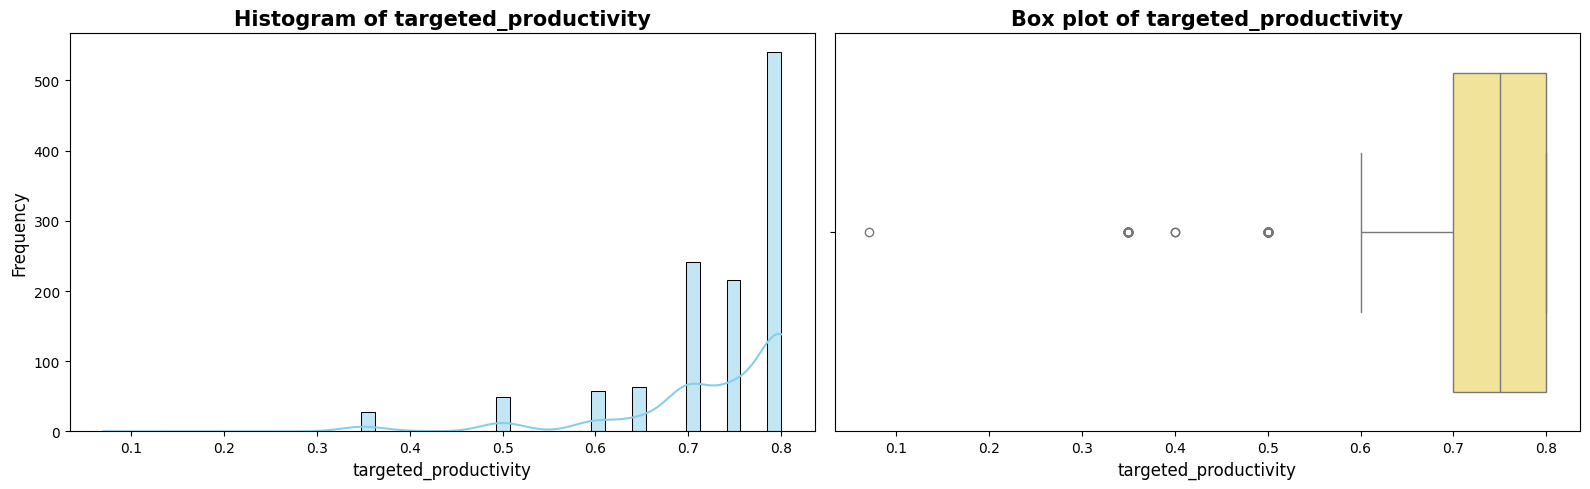

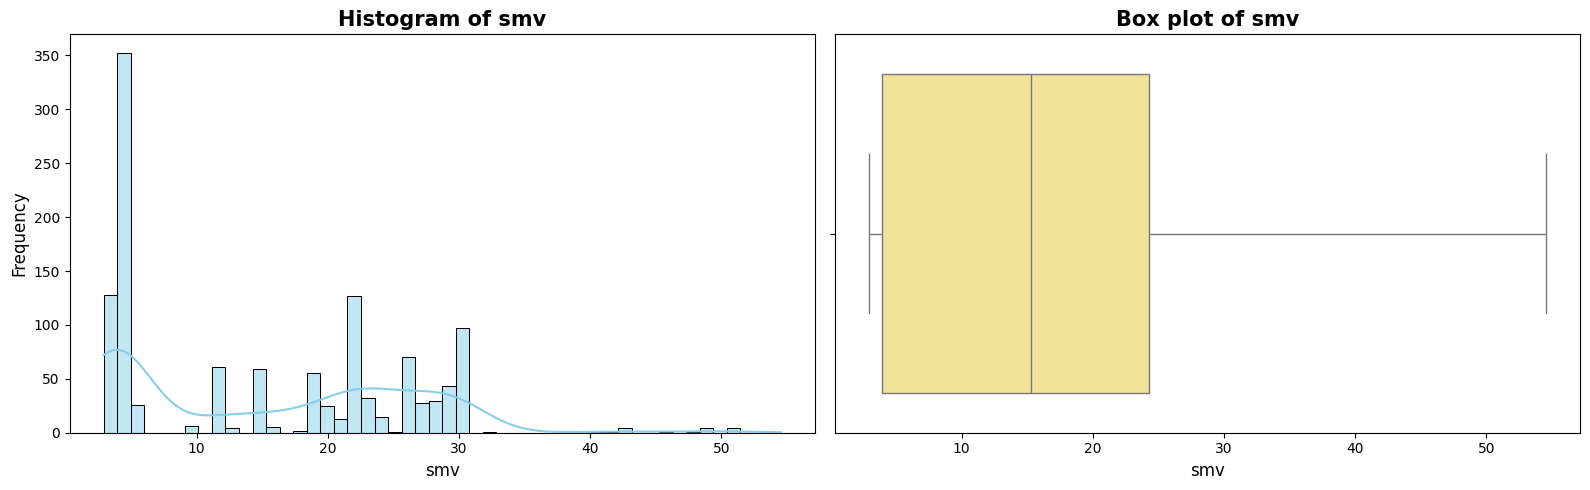

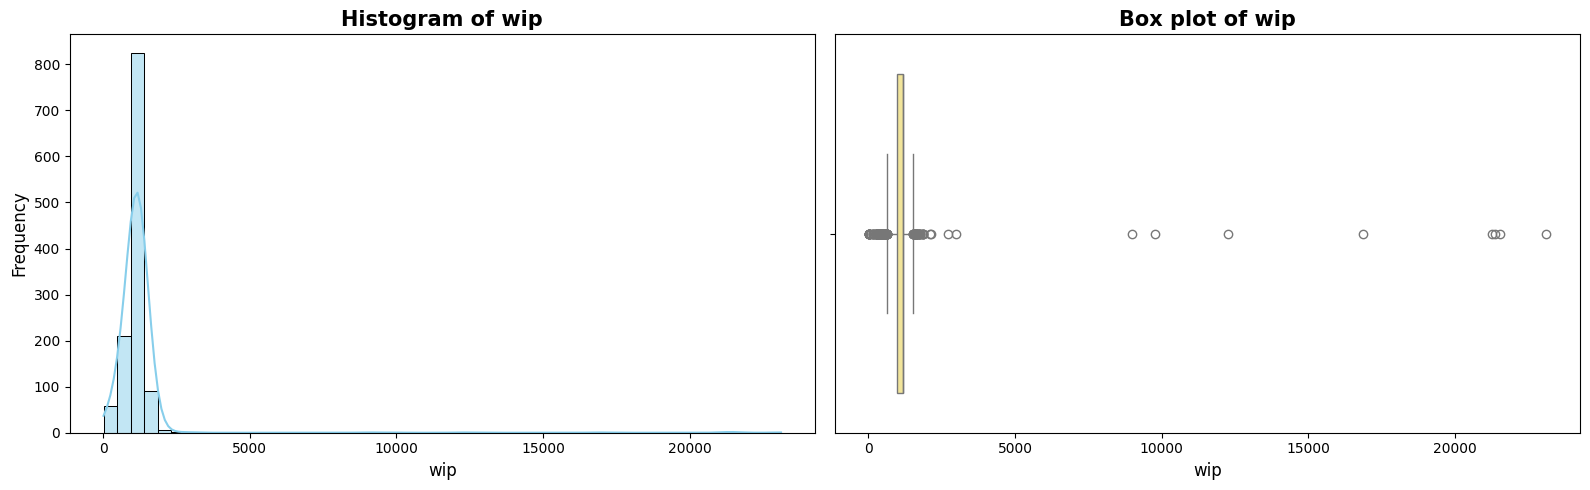

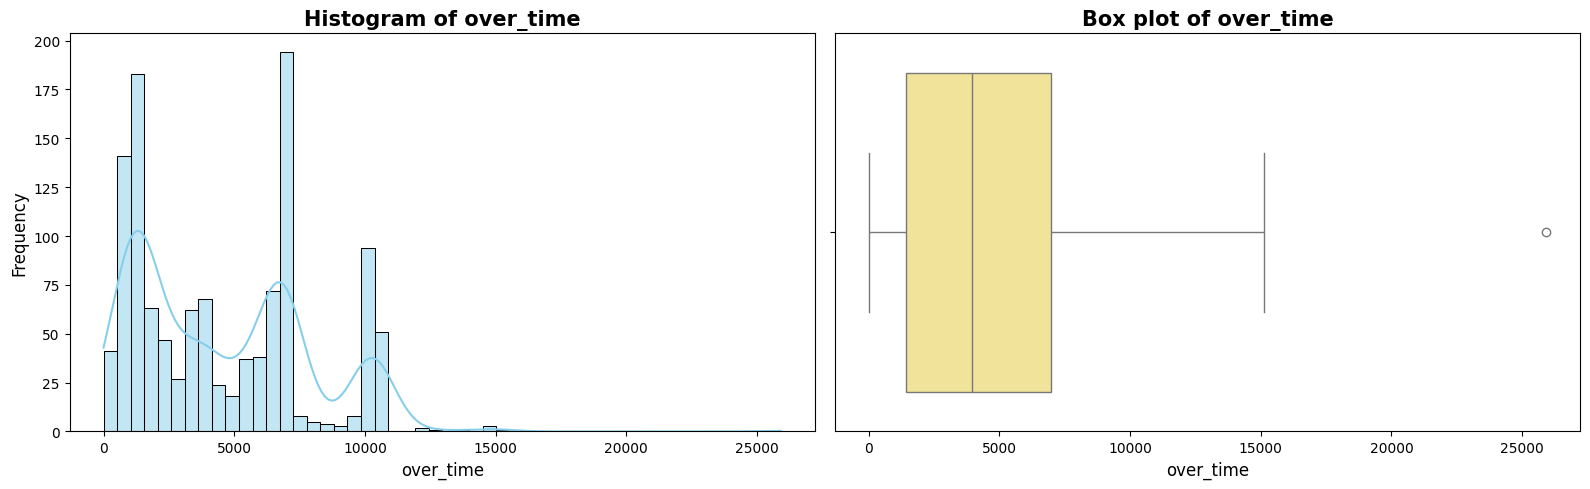

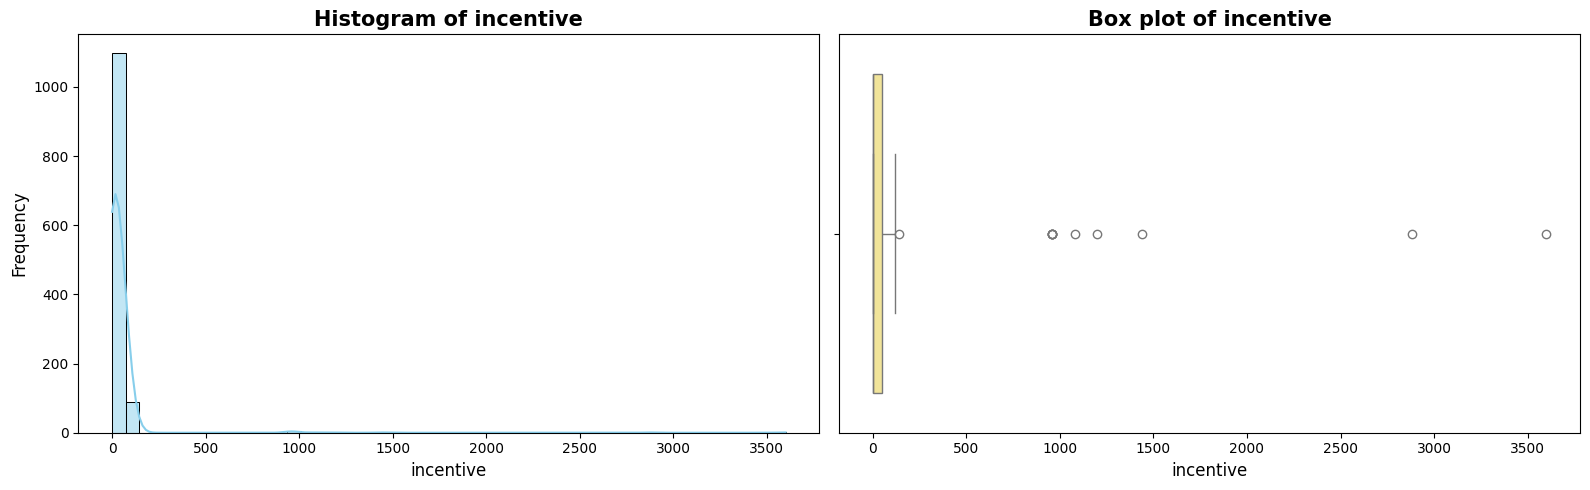

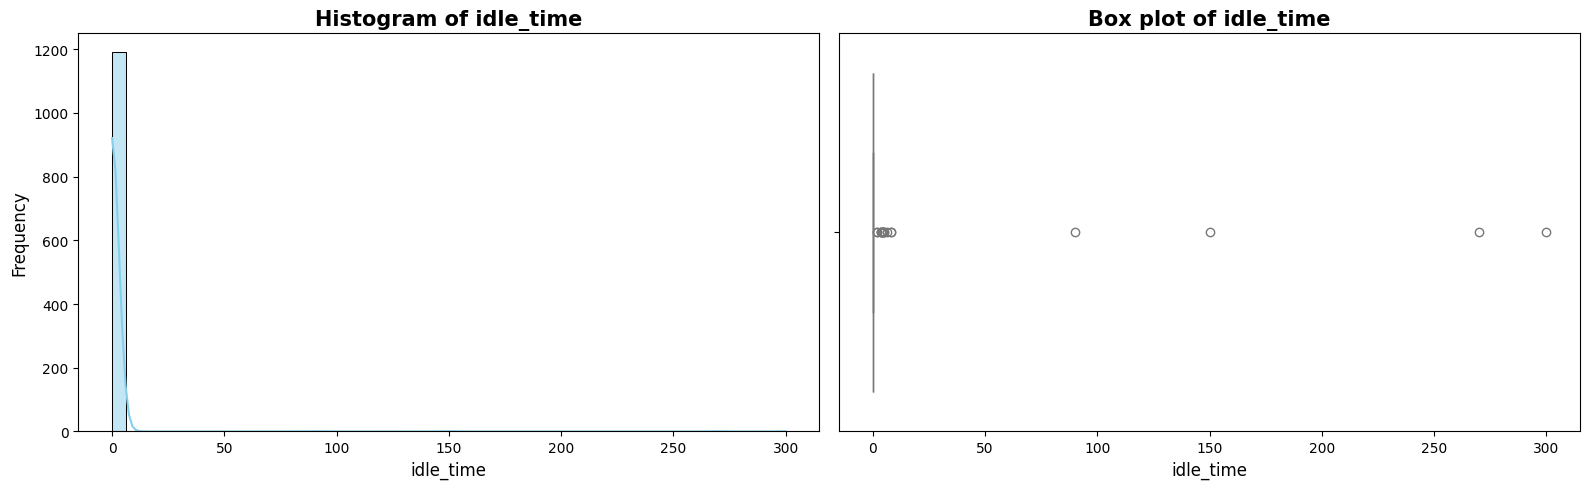

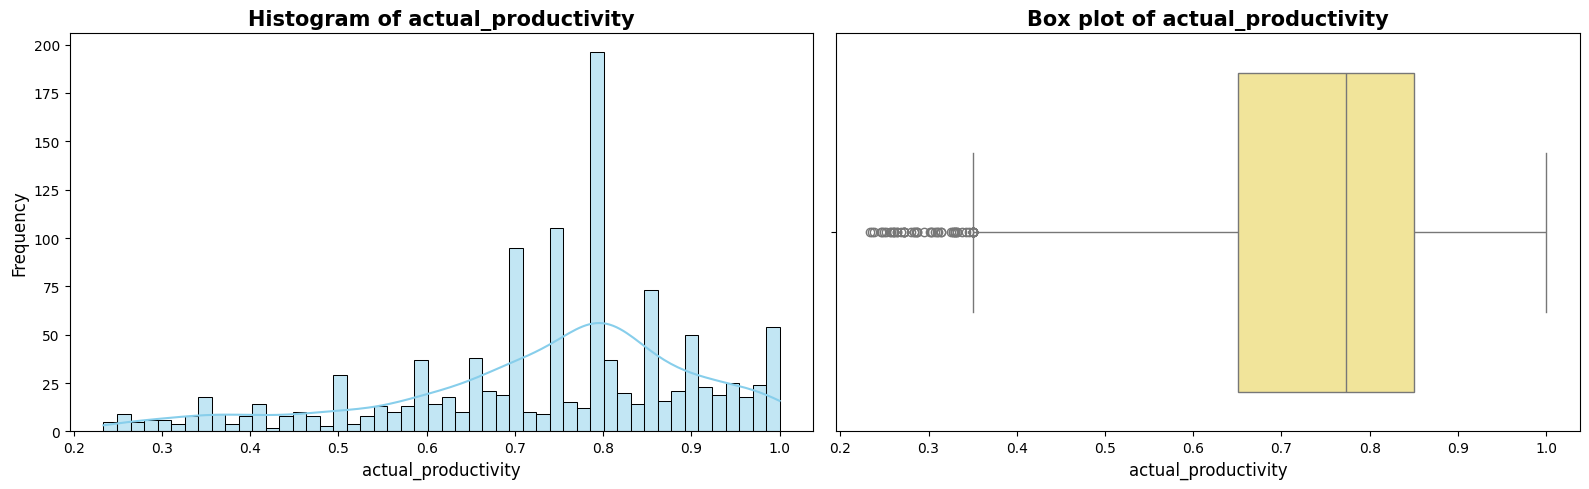

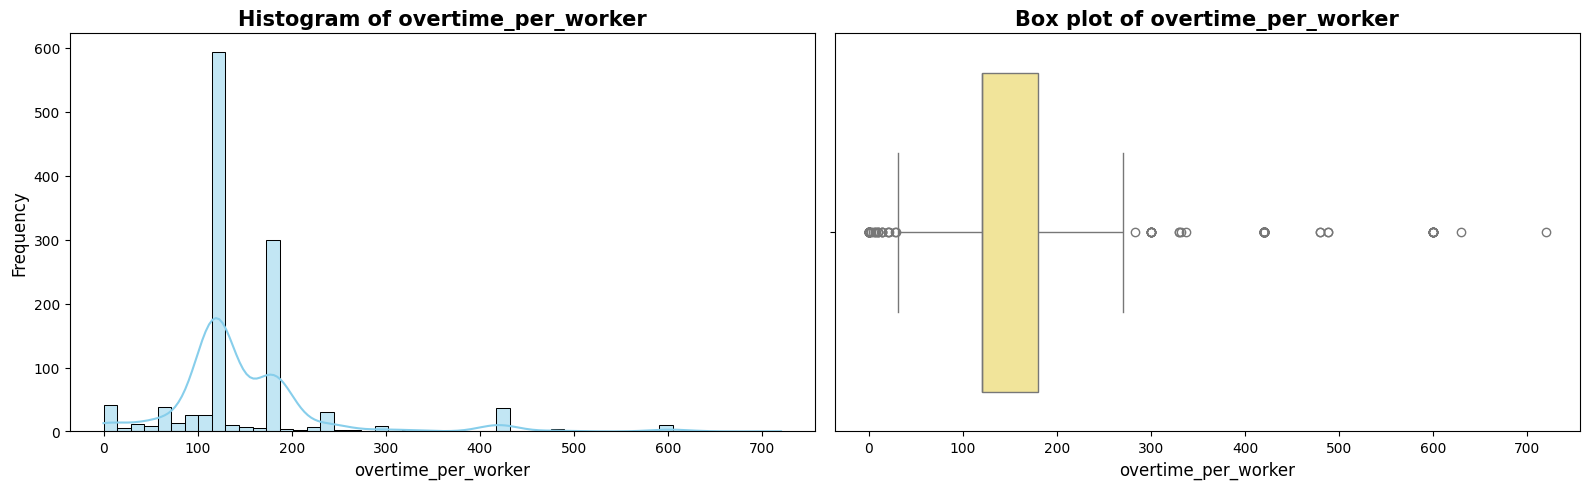

In [534]:
num_cols = ['targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'actual_productivity', 'overtime_per_worker']
plot_numerics(df[num_cols])

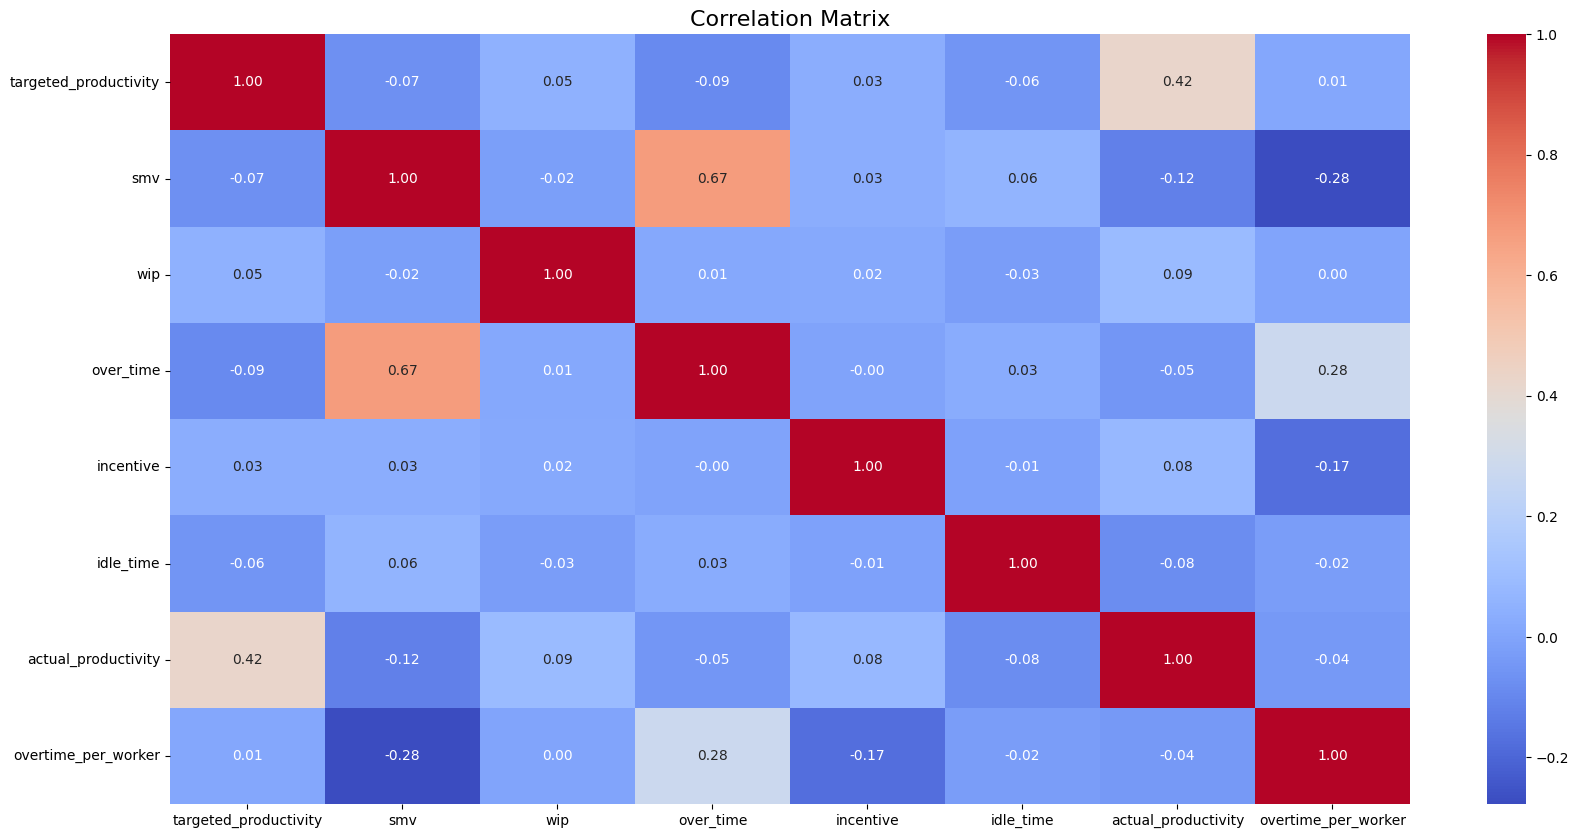

In [535]:
correlation_matrix = df[num_cols].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

## V-B. Productivity with regards to Teams and Departments (Orrin)

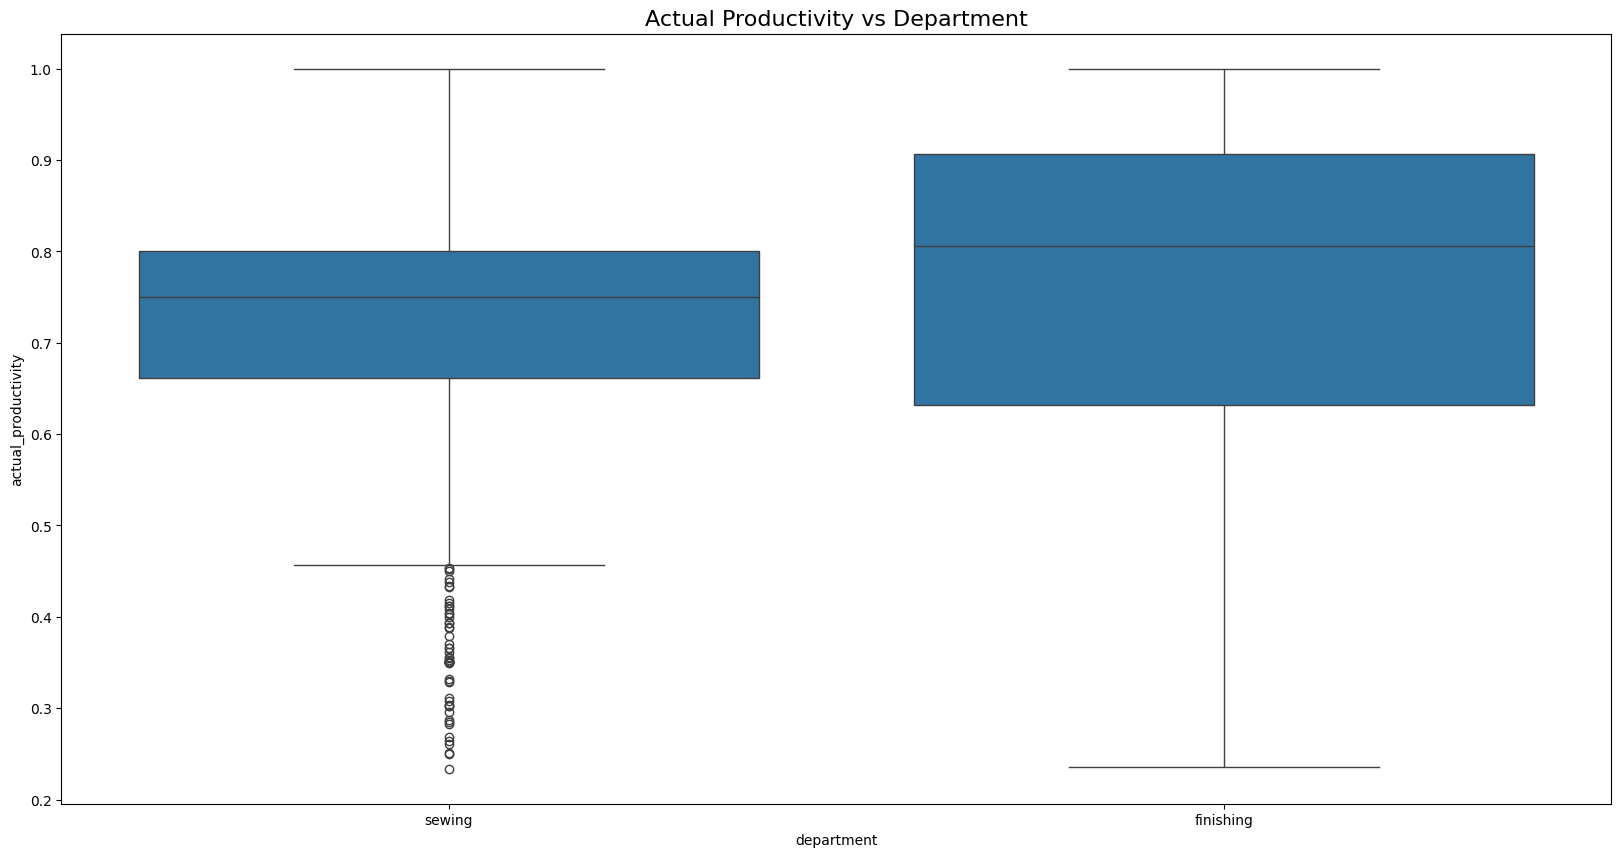

In [536]:
# actual productivity vs department
plt.figure(figsize=(20, 10))
sns.boxplot(x='department', y='actual_productivity', data=df_cleaned)
plt.title("Actual Productivity vs Department", fontsize=16)
plt.show()

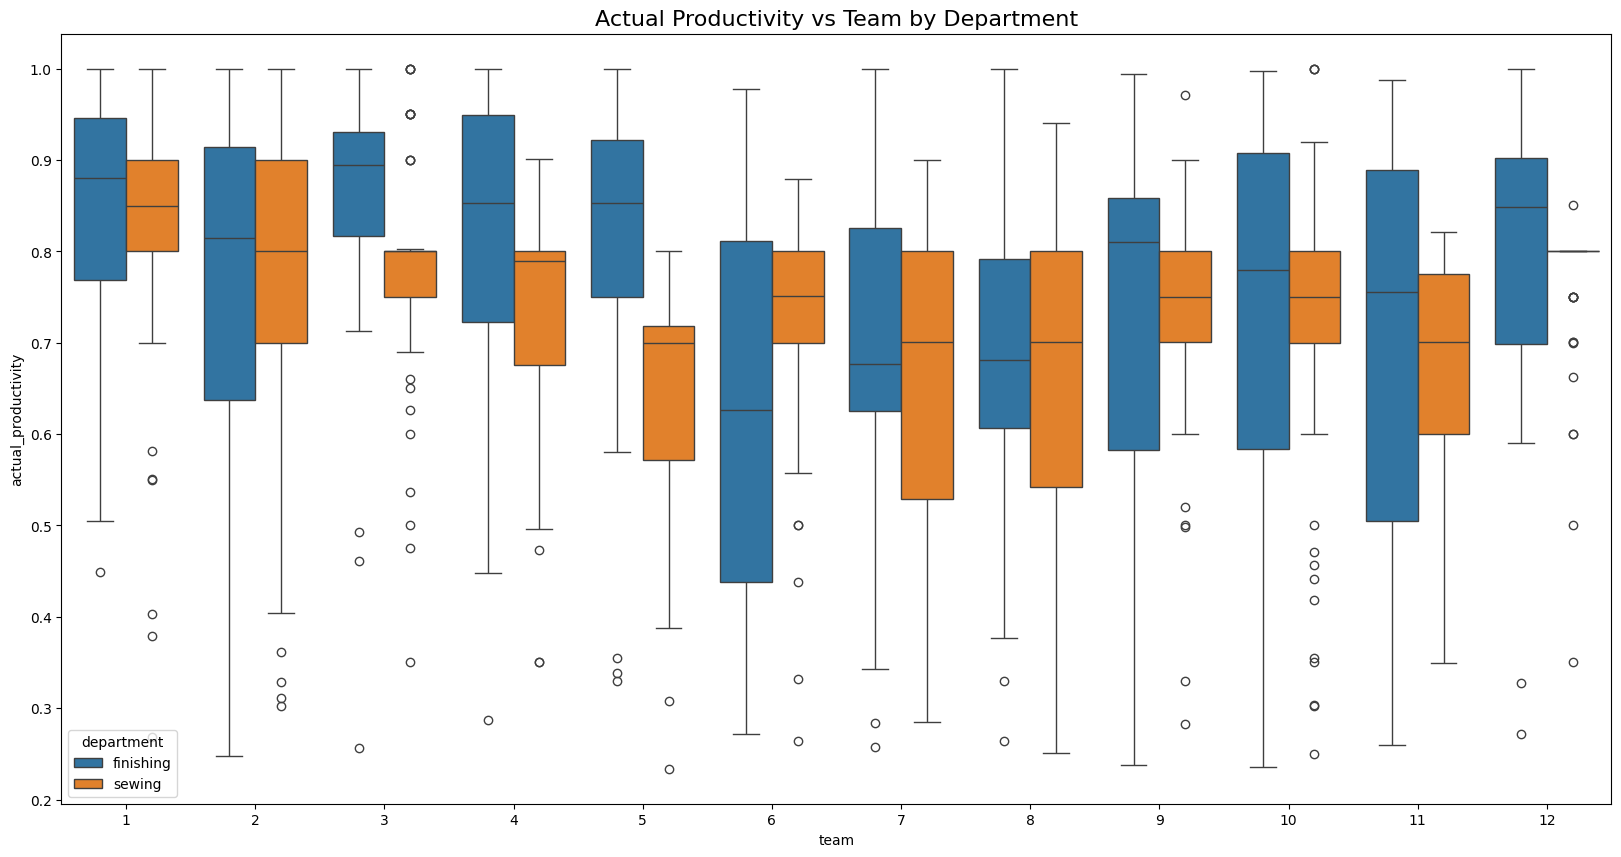

In [537]:
# actual productivity vs team by department
plt.figure(figsize=(20, 10))
sns.boxplot(x='team', y='actual_productivity', hue='department', data=df_cleaned)
plt.title("Actual Productivity vs Team by Department", fontsize=16)
plt.show()

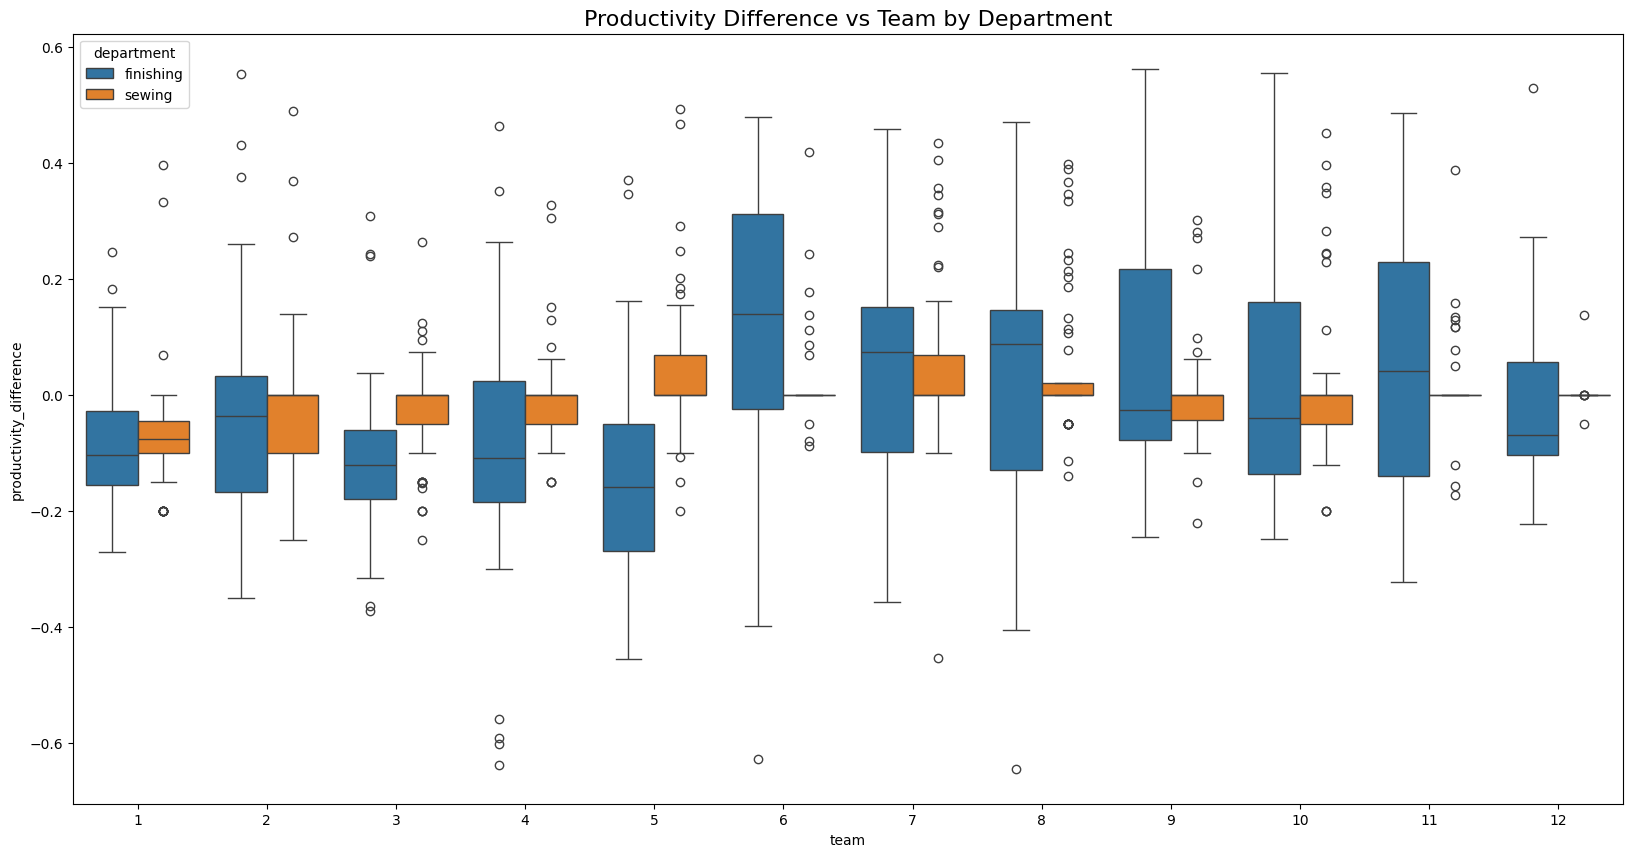

In [538]:
# productivity diff per team by department
df_cleaned['productivity_difference'] = df_cleaned['targeted_productivity'] - df_cleaned['actual_productivity']
plt.figure(figsize=(20, 10))
sns.boxplot(x='team', y='productivity_difference', hue='department', data=df_cleaned)
plt.title("Productivity Difference vs Team by Department", fontsize=16)
plt.show()

Lower numbered teams tend to be unable to reach productivity targets.

In [539]:
# number of workers per team by department in table format
workers_per_team = df_cleaned.groupby(['team', 'department'])['no_of_workers'].mean().reset_index()
workers_per_team = workers_per_team.pivot(index='team', columns='department', values='no_of_workers')
workers_per_team

department,finishing,sewing
team,,
1,9.673469,57.142857
2,11.673077,55.368421
3,12.243243,56.862069
4,13.456522,57.305085
5,9.742857,57.206897
6,9.000000,34.661017
7,9.926829,57.218182
8,9.075472,56.446429
9,8.869565,56.086207


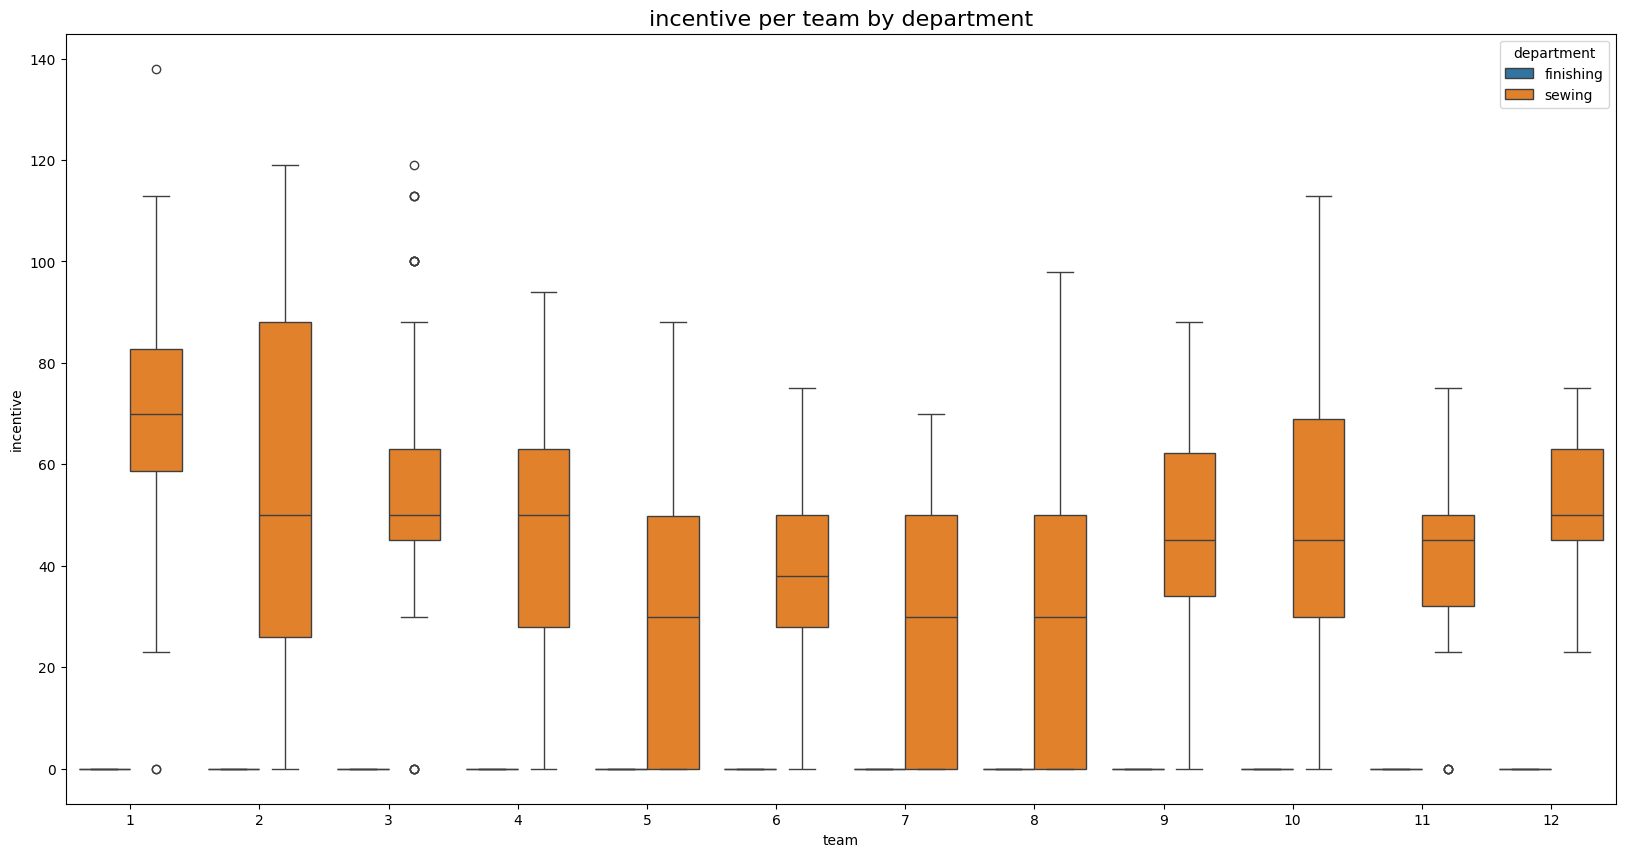

In [540]:
#could the issue be related to incentives?
df2 = df_cleaned.copy()
# remove incentive outliers
df2 = df2[df2['incentive'] < 700]

plt.figure(figsize=(20, 10))
sns.boxplot(x='team', y='incentive', hue='department', data=df2)
plt.title("incentive per team by department", fontsize=16)
plt.show()

Finishing team does not get incentives

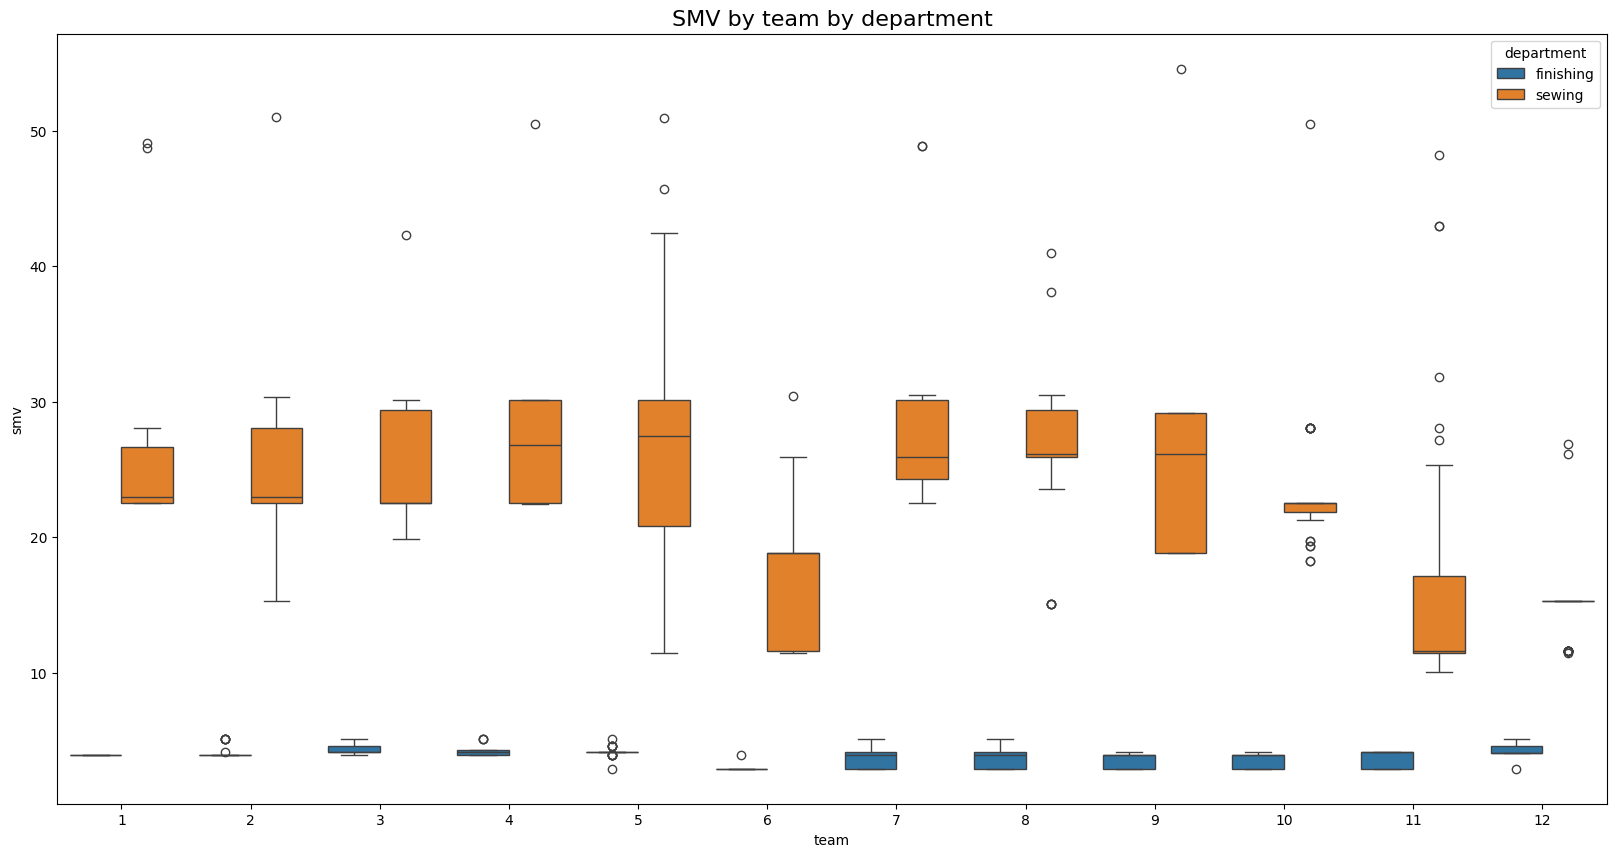

In [541]:
#perhaps the issue is in the smv
plt.figure(figsize=(20, 10))
sns.boxplot(x='team', y='smv', hue='department', data=df_cleaned)
plt.title("SMV by team by department", fontsize=16)
plt.show()

## V-C. Day of the Week and Quarter of the Month to Actual Productivity (Tean)

### Description

In the Philippines, a company typically pays its workers at the end of the 2nd and 4th week of every month. With this, it can be speculated that the actual productivity of the workers will be affected when in the proximity of those times as they anticipate receiving their paychecks. Additionally, with the chosen representation, it will also be possible to analyze actual productivity as the month goes by.

Relevant fields of the EDA:

Days of the Week:
- 'day_Monday'
- 'day_Tuesday'
- 'day_Wednesday'
- 'day_Thursday'
- 'day_Saturday'
- 'day_Sunday'

Quarters of the Month:
- 'quarter_Quarter1'
- 'quarter_Quarter2'
- 'quarter_Quarter3'
- 'quarter_Quarter4'
- 'quarter_Quarter5'

Actual Productivity:
- 'actual_productivity'

### Data Transformation

Seclude the relevant fields for the EDA.

In [542]:
day_quarter_productivity_df = df[['day_Monday', 'day_Tuesday', 'day_Wednesday', 'day_Thursday', 'day_Saturday', 'day_Sunday', 'quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3', 'quarter_Quarter4', 'quarter_Quarter5', 'actual_productivity']]

day_quarter_productivity_df

,day_Monday,day_Tuesday,day_Wednesday,day_Thursday,day_Saturday,day_Sunday,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5,actual_productivity
0,False,False,False,True,False,False,True,False,False,False,False,0.940725
1,False,False,False,True,False,False,True,False,False,False,False,0.886500
2,False,False,False,True,False,False,True,False,False,False,False,0.800570
3,False,False,False,True,False,False,True,False,False,False,False,0.800570
4,False,False,False,True,False,False,True,False,False,False,False,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...
1192,False,False,True,False,False,False,False,True,False,False,False,0.628333
1193,False,False,True,False,False,False,False,True,False,False,False,0.625625
1194,False,False,True,False,False,False,False,True,False,False,False,0.625625
1195,False,False,True,False,False,False,False,True,False,False,False,0.505889


Transform the relevant fields into more easily processable values.

In [543]:
# Ensure we are working with a copy of the DataFrame
day_quarter_productivity_df = day_quarter_productivity_df.copy()

# Make day_of_week and quarter columns
day_quarter_productivity_df.loc[:, 'day_of_week'] = day_quarter_productivity_df[['day_Monday', 'day_Tuesday', 'day_Wednesday', 'day_Thursday', 'day_Saturday', 'day_Sunday']].idxmax(axis=1).str.split('_').str[1]
day_quarter_productivity_df.loc[:, 'quarter'] = day_quarter_productivity_df[['quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3', 'quarter_Quarter4', 'quarter_Quarter5']].idxmax(axis=1).str.split('_').str[1]

# Drop the one-hot encoded columns
day_quarter_productivity_df = day_quarter_productivity_df.drop(['day_Monday', 'day_Tuesday', 'day_Wednesday', 'day_Thursday', 'day_Saturday', 'day_Sunday', 'quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3', 'quarter_Quarter4', 'quarter_Quarter5'], axis=1)

day_quarter_productivity_df

,actual_productivity,day_of_week,quarter
0,0.940725,Thursday,Quarter1
1,0.886500,Thursday,Quarter1
2,0.800570,Thursday,Quarter1
3,0.800570,Thursday,Quarter1
4,0.800382,Thursday,Quarter1
...,...,...,...
1192,0.628333,Wednesday,Quarter2
1193,0.625625,Wednesday,Quarter2
1194,0.625625,Wednesday,Quarter2
1195,0.505889,Wednesday,Quarter2


### Data Representation and Visualization

Pivot Tables specialize in representing grouped data of many dimensions into a neat table format, where the rows and columns are the groupings and the cells are the featured values.
As the EDA features 1 quantitative and 2 qualitative features, a Pivot Table should be the most fitting representation. 
This lets us create a table who's columns are the days of the week, rows are the quarters of the month, and cells are the means of the actual productivities grouped by the columns and rows.

In [544]:
# Create a pivot table
pivot_table = day_quarter_productivity_df.pivot_table(
    values='actual_productivity', 
    index='quarter', 
    columns='day_of_week', 
    aggfunc='mean'
)

# Sort the days of the week
pivot_table = pivot_table[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday']]

pivot_table

day_of_week,Sunday,Monday,Tuesday,Wednesday,Thursday,Saturday
quarter,,,,,,
Quarter1,0.744070,0.746133,0.751094,0.755135,0.749143,0.761843
Quarter2,0.748086,0.739473,0.760480,0.738996,0.719283,0.741212
Quarter3,0.677855,0.706273,0.700208,0.695238,0.722660,0.730730
Quarter4,0.716707,0.737127,0.737412,0.712093,0.654613,0.700899
Quarter5,NaN,NaN,NaN,NaN,0.791633,0.854926


To better visualize the Pivot Table, a Heat Map can be made to highlight the trends of the data in each grouping.

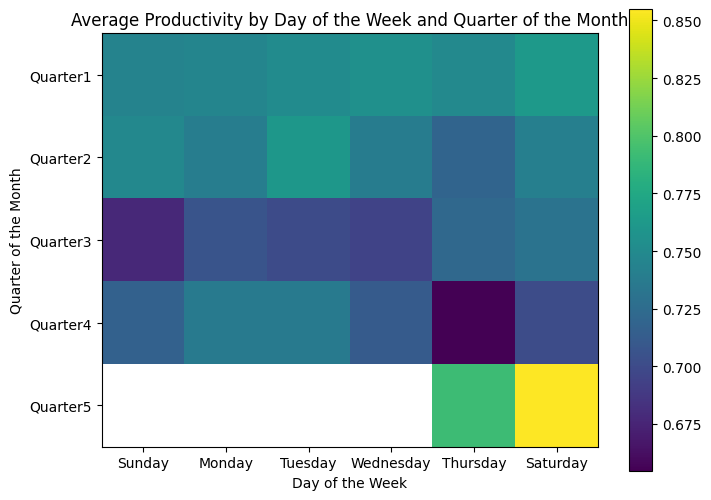

In [545]:
# Plot the pivot table
plt.figure(figsize=(8, 6))
plt.imshow(pivot_table, cmap='viridis')
plt.colorbar()
plt.xticks(np.arange(6), pivot_table.columns)
plt.yticks(np.arange(5), pivot_table.index)
plt.xlabel('Day of the Week')
plt.ylabel('Quarter of the Month')
plt.title('Average Productivity by Day of the Week and Quarter of the Month')
plt.show()

### Findings

- Actual productivity of workers decreases as the month goes by, with the later half of the month being darker than the start. 
- The start of Quarter 3 (0.677855) and the end of Quarter 4 (0.654613) are especially dark, suggesting that the workers are less productive after receiving their 1st monthly paycheck and before receiving their 2nd monthly paycheck.
- Quarter 5 is very productive as its colors are way brighter. However, this may be an outlier due to the only Quarter 5 days being 1/29/2015 (0.791633) and 1/31/2025 (0.854926).

## V-D. Overtime in relation to Standard Minute Value and Number of Workers for each Department (Tan Ai)

In [546]:
df.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,overtime_per_worker
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.551378,0.734461,148.533406
std,3.463963,0.097891,10.943219,1395.647261,3348.823563,160.182643,12.709757,3.268987,0.427848,22.152559,0.173380,86.042508
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705,0.000000
25%,3.000000,0.700000,3.940000,970.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307,120.000000
50%,6.000000,0.750000,15.260000,1190.465991,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333,120.000000
75%,9.000000,0.800000,24.260000,1190.465991,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253,180.000000
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.000000,720.000000


In [547]:
smv_nw_overtime_df = df[(df["department_sewing"] == True)][['smv', 'no_of_workers', 'over_time']]

In [548]:
smv_nw_overtime_df = smv_nw_overtime_df.copy()

smv_nw_overtime_df

,smv,no_of_workers,over_time
0,26.16,59.0,7080
2,11.41,30.0,3660
3,11.41,30.0,3660
4,25.90,56.0,1920
5,25.90,56.0,6720
...,...,...,...
1187,26.82,59.0,7080
1188,26.82,58.0,6960
1189,30.48,57.0,6840
1190,23.41,38.0,4560


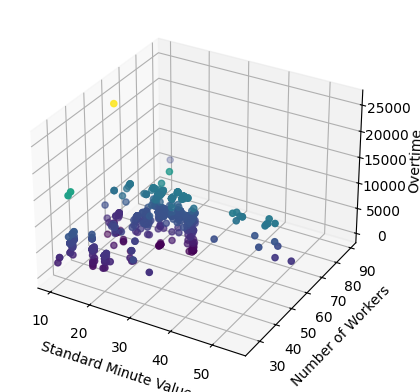

In [549]:
x = smv_nw_overtime_df['smv']
y = smv_nw_overtime_df['no_of_workers']
z = smv_nw_overtime_df['over_time']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c=z, cmap='viridis')

ax.set_xlabel('Standard Minute Value')
ax.set_ylabel('Number of Workers')
ax.set_zlabel('Overtime')

plt.show()

# VI. Initial Model Training

## VI-0. Train Test Set Separation

`X` is the feature table and will all features except `actual_productivity`.

`y` is the label of the feature table and will only contain `actual_productivity`.

In [550]:
X = df.drop(columns=['actual_productivity']).values
y = df['actual_productivity'].values

print('X ', X.shape)
print('y ', y.shape)

X  (1197, 24)
y  (1197,)


Divide the dataset into train and test sets, where `20%` of the data will be placed in the test set.

Random state is set to `69` for uniformity.

In [551]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

Display the shape of the train, validation, and test sets.

In [552]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)

print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (957, 24)
y_train (957,)
X_test (240, 24)
y_test (240,)


Display head and columns to check values

In [553]:
print(pd.DataFrame(X_train).head())

   0     1      2            3      4   5    6  7  8     9           10  \
0   9  0.75   3.94  1190.465991    960   0  0.0  0  0   8.0       120.0   
1  11  0.35  12.52        287.0  25920  38  0.0  0  0  54.0       480.0   
2   4   0.8  22.52      23122.0   5940  50  0.0  0  0  56.0  106.071429   
3   9   0.8   3.94  1190.465991   1800   0  0.0  0  0  10.0       180.0   
4   2   0.8  28.08        749.0  10350  63  0.0  0  0  57.0  181.578947   

      11     12     13     14     15     16     17     18     19     20  \
0   True  False  False  False  False  False  False   True   True  False   
1  False   True  False  False  False   True  False  False  False   True   
2  False   True   True  False  False  False  False  False   True  False   
3   True  False  False   True  False  False  False  False  False  False   
4  False   True  False   True  False  False  False  False  False   True   

      21     22     23  
0  False  False  False  
1  False  False  False  
2  False  False  False 

As sklearn's StandardScaler standardizes all feature columns regardless of datatype, need to exclude boolean columns from the standardization to maintain their values

Get all non-boolean columns for standardization

In [554]:
# Get all columns in X_train that are not boolean
non_boolean_columns = []
for i in range(X_train.shape[1]):
    if len(np.unique(X_train[:, i])) != 2:
        non_boolean_columns.append(i)

non_boolean_columns

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Standardize the non-boolean columns based on X_train.

In [555]:
# Scale all columns that are not boolean
ct = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), non_boolean_columns)
    ],
    remainder='passthrough'
)
ct.fit(X_train)

X_train_scaled = ct.transform(X_train)
X_test_scaled = ct.transform(X_test)

Display head and columns of standardizes datasets to check values

In [556]:
print(pd.DataFrame(X_train_scaled).head())

         0         1         2          3         4         5         6   \
0  0.727334  0.217848  -1.00221   0.008041 -1.062481 -0.228326 -0.058383   
1  1.298811 -3.747545 -0.228423  -0.646291  6.382751 -0.011269 -0.058383   
2 -0.701358  0.713522  0.673426  15.891862  0.422986  0.057276 -0.058383   
3  0.727334  0.713522  -1.00221   0.008041 -0.811921 -0.228326 -0.058383   
4 -1.272835  0.713522  1.174854  -0.311689  1.738429  0.131532 -0.058383   

        7         8         9         10     11     12     13     14     15  \
0 -0.11777 -0.344064 -1.190787 -0.327128   True  False  False  False  False   
1 -0.11777 -0.344064  0.887508  3.802866  False   True  False  False  False   
2 -0.11777 -0.344064  0.977869  -0.48692  False   True   True  False  False   
3 -0.11777 -0.344064 -1.100427  0.361204   True  False  False   True  False   
4 -0.11777 -0.344064  1.023049  0.379318  False   True  False   True  False   

      16     17     18     19     20     21     22     23  
0  False

Function to display MSE, RMSE, MAE, and R2 given a regressor

In [557]:
def getModelPerformance(model, model_name:str, scaled:bool):
    
    # Predictions
    if scaled:
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
    else:
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
    # Clip the values to be between 0 and 1
    y_train_pred = np.clip(y_train_pred, 0, 1)
    y_test_pred = np.clip(y_test_pred, 0, 1)

    # MSE
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    print(model_name + ' Train MSE:', train_mse)
    print(model_name + ' Test MSE:', test_mse)
    print('')
    print(model_name + ' Train RMSE:', np.sqrt(train_mse))
    print(model_name + ' Test RMSE:', np.sqrt(test_mse))
    print('')
    print(model_name + ' Train MAE:', mean_absolute_error(y_train, y_train_pred))
    print(model_name + ' Test MAE:', mean_absolute_error(y_test, y_test_pred))
    print('')
    print(model_name + ' Train R^2:', r2_score(y_train, y_train_pred))
    print(model_name + ' Test R^2:', r2_score(y_test, y_test_pred))

## VI-A. Linear Regression

In [558]:
linear_regression = LinearRegression()
linear_regression.fit(X_train_scaled, y_train)

y_predicted = linear_regression.predict(X_test_scaled)
rmse = np.sqrt(np.mean((y_predicted - y_test) ** 2))
print(f'Root Mean Squared Error: {rmse}')

# plot with actual productivity and predicted productivity in different colors
# plt.figure(figsize=(8, 6))
# plt.scatter(scaled_y_val, y_predicted, color='red', label='Predicted Values')  
# plt.scatter(scaled_y_val, scaled_y_val, color='green', label='Actual Values')  
# min_val = min(scaled_y_val.min(), y_predicted.min())
# max_val = max(scaled_y_val.max(), y_predicted.max())
# plt.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='Ideal Fit (Actual = Predicted)')
# plt.xlabel('Actual Productivity')
# plt.ylabel('Predicted Productivity')
# plt.title('Actual Productivity vs Predicted Productivity')
# plt.legend()
# plt.grid()
# plt.show()


Root Mean Squared Error: 0.15440194272921154


In [559]:
# linear regression with polyfit
poly = PolynomialFeatures(degree=2)
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print('X_poly', X_train_poly.shape)
print('X_test_poly', X_test_poly.shape)

X_poly (957, 325)
X_test_poly (240, 325)


In [560]:
linear_regression = LinearRegression()
model = linear_regression.fit(X_train_poly, y_train)

y_predicted = model.predict(X_test_poly)
rmse = np.sqrt(np.mean((y_predicted - y_test) ** 2))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 43527980.862031594


## VI-B. Random Forest

Decision Trees have been used for classification and regression problems, however it faces the issue of being prone to bias and overfitting due to the nature of the algorithm, therefore to remedy this we have decided to make use of a Random Forest model which is an ensemble learning method that makes use of decision trees, where instead of creating a single decision tree, multiple decision trees are made with each considering features differently and therefore making different decisions from the other trees.

The nature of Random Forest solves some of the prior issues found in decision trees such as bias and overfitting due to the bootstrap aggregation sampling method, however its performance in classification vs regression is still the same where it performs much better in classification. 

In [561]:
import sklearn.ensemble
from sklearn import metrics
#rf_regressor = sklearn.ensemble.RandomForestRegressor(n_estimators= , max_depth= , min_samples_split= , min_samples_leaf= , )
rf_regressor = sklearn.ensemble.RandomForestRegressor(random_state=random_seed)

In [562]:
rf_regressor.fit(X_train, y_train)


RandomForestRegressor(random_state=69)

In [563]:
getModelPerformance(rf_regressor, 'Initial Random Forest Model', False)

Initial Random Forest Model Train MSE: 0.0019615031499284306
Initial Random Forest Model Test MSE: 0.018514849802299428

Initial Random Forest Model Train RMSE: 0.0442888603367532
Initial Random Forest Model Test RMSE: 0.13606928309614713

Initial Random Forest Model Train MAE: 0.026943753521431527
Initial Random Forest Model Test MAE: 0.079271717871125

Initial Random Forest Model Train R^2: 0.9361814665058318
Initial Random Forest Model Test R^2: 0.32031061068997524


## VI-C. Neural Network

Neural Networks are a robust tool for predicting values due to their ability to capture complex, non-linear relationships between input features. 
With columns ranging from operational metrics like SMV, WIP, and over_time, to dynamic factors such as idle_time and no_of_style_change, Neural Networks can effectively process and learn from the intricate patterns and interactions among these variables. 
Additionally, their adaptability to various data scales and distributions makes them particularly suited to handle the diverse nature of the dataset, potentially leading to more accurate and insightful predictions of actual productivity. This capacity to model complex dependencies sets Neural Networks apart as a powerful predictive tool in this context.

To create the Neural Network model for the dataset, scikit-learn's Multi-layer Perceptron Regressor (MLP Regressor) will be used. 
It is a straightforward implementation of the supervised Neural Network model intended for simple use cases and learning, and it is complete with interconnected nodes, forwardpropagation, backpropagation, weight adjustment, and more.
Moreover, the MLP Regressor also comes with various hyperparameters that can be tuned to optimize performance and achieve high accuracy in predictive modeling tasks. (1.17. Neural Network Models (Supervised), n.d.).

Additionally, as the output of the regressor should only be between 0 and 1, to prevent it from having values beyond those, a custom MLPRegressor was made with with predictions being clipped at 0 and 1 before being returned.
By doing so, the model can train without needing to worry about going above or below the value ranges.

SCRAPPED: Model would exploit clip and always go on top

In [564]:
# class ClippedMLPRegressor(BaseEstimator, RegressorMixin):
    
#     def __init__(self, **kwargs):
#         self.model = MLPRegressor(**kwargs)
#         self.max_iter = self.model.max_iter
    
#     def fit(self, X, y):
#         self.model.fit(X, y)
#         return self
    
#     def partial_fit(self, X, y):
#         self.model.partial_fit(X, y)
#         return self
    
#     def get_params(self, deep: bool = True) -> dict:
#         return self.model.get_params(deep)
    
#     def predict(self, X):
#         predictions = self.model.predict(X)
#         return np.clip(predictions, 0, 1)

In [565]:
# Create MLPRegressor model
initial_nn_model = MLPRegressor(random_state=random_seed)

Main hyperparameters:
- Neurons and hidden layers: [100]
- Solver and Optimizer: ADAM
- Activation Function: ReLU
- Max Iterations: 200
- Initial Learning Rate: 0.001
- Learning Rate Change: constant
- Regularization Constant: 0.0001
- Random Sate: 69

The hyperparameters used for the initial model training are the default parameters of the MLPRegressor model. 
This is to set a base standard to which the model can improve upon when tuning. 
In general, it can be noted that the default parameters themselves are already sufficient for most use cases, already including advanced Neural Network optimizations like ADAM and ReLU.

Out of all the hyperparameters, the most significant is that there is only 1 hidden layer with 100 neurons. 
As the initial model, it is generally better to have a simple model with lesser neurons and hidden layers, then slowly increase the number over iterations.
This way, it is possible to see how the model improves with regards to the hyperparameters (Karpathy, 2019; Dutta, 2024).

In [566]:
initial_nn_model.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 69,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

To see how the model trains and improves, the training of the initial MLPRegressor will use partial_fit to fit it per epoch, and only stop when reach max iterations.
After each epoch, the error metrics for both train and test sets will be stored for evaluation later on, and at every 5th epoch, they will be displayed.
As the MLP Regressor model is sensitive to feature scaling, use the scaled versions of X_train and X_test to train the model. (1.17. Neural Network Models (Supervised), n.d.).

In [567]:
# Use partial_fit to train the model and get the error metrics for each epoch

nn_epoch_num = 1
nn_epoch_train_mse = []
nn_epoch_train_mae = []
nn_epoch_r2 = []
nn_epoch_test_mse = []
nn_epoch_test_mae = []
nn_epoch_test_r2 = []

while True:
    
    # Train the model for one epoch
    initial_nn_model.partial_fit(X_train_scaled, y_train)
    
    # Predict the training set
    y_train_pred = initial_nn_model.predict(X_train_scaled)
    y_test_pred = initial_nn_model.predict(X_test_scaled)
    
    # Clip the values to be between 0 and 1
    y_train_pred = np.clip(y_train_pred, 0, 1)
    y_test_pred = np.clip(y_test_pred, 0, 1)
    
    # Calculate the error metrics
    train_rmse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append the mean squared error to the list
    nn_epoch_train_mse.append(train_rmse)
    nn_epoch_train_mae.append(train_mae)
    nn_epoch_r2.append(train_r2)
    nn_epoch_test_mse.append(test_rmse)
    nn_epoch_test_mae.append(test_mae)
    nn_epoch_test_r2.append(test_r2)
    
    # Print the epoch number and error metrics for every 10th epoch
    if nn_epoch_num % 10 == 0:
        print(f"Epoch: {nn_epoch_num}")
        print(f"\tTrain - RMSE: {np.sqrt(train_rmse)}, MAE: {train_mae}, R^2: {train_r2}")
        print(f"\tTest  - RMSE: {np.sqrt(test_rmse)}, MAE: {test_mae}, R^2: {test_r2}")
    
    # Break the loop if reach max_iter
    if nn_epoch_num == initial_nn_model.max_iter:
        break
    else:
        # Increment the epoch number
        nn_epoch_num += 1

Epoch: 10
	Train - RMSE: 0.1728309652447289, MAE: 0.13200375373131124, R^2: 0.028146235645170936
	Test  - RMSE: 0.1941454633368773, MAE: 0.1491281123293754, R^2: -0.38370907825773015
Epoch: 20
	Train - RMSE: 0.14561266918627128, MAE: 0.11130904266257854, R^2: 0.31014766908734903
	Test  - RMSE: 0.17365303326939022, MAE: 0.12893007000494153, R^2: -0.10701892221716647
Epoch: 30
	Train - RMSE: 0.13276005677241448, MAE: 0.09922660344813024, R^2: 0.4265538131799985
	Test  - RMSE: 0.16435547942234943, MAE: 0.1197920040102302, R^2: 0.008349416046493086
Epoch: 40
	Train - RMSE: 0.12469016884010872, MAE: 0.09134075073202398, R^2: 0.4941494386072609
	Test  - RMSE: 0.1597861217446902, MAE: 0.11497041211195178, R^2: 0.0627220315881708
Epoch: 50
	Train - RMSE: 0.11902811000064448, MAE: 0.0861326043380875, R^2: 0.5390467454728614
	Test  - RMSE: 0.15743450828123007, MAE: 0.11275415394032627, R^2: 0.09010734137935317
Epoch: 60
	Train - RMSE: 0.11462378655332589, MAE: 0.08224809624867824, R^2: 0.5725283

After the model has been trained, display its error metrics for both train and test sets to show its performance. The analysis for the errors will be featured in the Error Analysis section.

In [568]:
getModelPerformance(initial_nn_model, 'Initial Neural Network', True)

Initial Neural Network Train MSE: 0.00765604684632986
Initial Neural Network Test MSE: 0.023414102891207895

Initial Neural Network Train RMSE: 0.08749883911418402
Initial Neural Network Test RMSE: 0.15301667520635748

Initial Neural Network Train MAE: 0.059153600656400594
Initial Neural Network Test MAE: 0.10458704682380317

Initial Neural Network Train R^2: 0.75090650141793
Initial Neural Network Test R^2: 0.14045658132259198


# VII. Error Analysis

## VII-0. Plotting Helper Functions

In [569]:
def showPredToActualTable(y_test, y_pred, show_instances, is_test):
    string = 'Test' if is_test else 'Train'
    return pd.DataFrame({'Predicted Productivity': y_pred[:show_instances], string + ' Dataset Productivity': y_test[:show_instances]})

In [570]:
def plotTrainingTestErrors(train_rmse, train_mae, test_rmse, test_mae):
    # Plot the training and testing errors
    plt.figure(figsize=(12, 6))
    plt.plot(train_rmse, label='Train RMSE', color='blue', linestyle="-")
    plt.plot(train_mae, label='Train MAE', color='blue', linestyle="--")
    plt.plot(test_rmse, label='Test RMSE', color='red', linestyle="-")
    plt.plot(test_mae, label='Test MAE', color='red', linestyle="--")
    plt.title('Training and Testing Errors')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid()
    plt.show()

In [571]:
def plotTrainingTestR2(train_r2, test_r2):
    # Plot the training and testing R^2
    plt.figure(figsize=(12, 6))
    plt.plot(train_r2, label='Train R^2', color='blue')
    plt.plot(test_r2, label='Test R^2', color='red')
    plt.title('Training and Testing R^2')
    plt.xlabel('Epoch')
    plt.ylabel('R^2')
    plt.legend()
    plt.grid()
    plt.show()

In [572]:
def plotProductivityError(y_test, y_pred, model_name, is_test):
    string = 'Test' if is_test else 'Train'
    indices = np.arange(len(y_pred))

    plt.figure(figsize=(25, 6))
    plt.plot(indices, y_pred, label=model_name+' Predicted Productivity', marker='', linestyle='-', color='blue', alpha=0.7)
    plt.plot(indices, y_test, label=string + ' Dataset Productivity', marker='', linestyle='--', color='red', alpha=0.7)

    plt.title("Comparison of Predicted vs " + string + " Dataset Productivity for " + model_name)
    plt.xlabel("Sample Index")
    plt.ylabel("Productivity")
    plt.legend()
    plt.grid(True)

    plt.show()

In [573]:
def plotProductivityDistribution(y_test, y_pred, model_name, is_test):
    string = 'Test' if is_test else 'Train'
    min_value = min(np.min(y_test), np.min(y_pred))
    max_value = max(np.max(y_test), np.max(y_pred))
    bin_edges = np.linspace(min_value, max_value, 50)

    plt.figure(figsize=(12, 6))

    sns.histplot(y_pred, kde=True, color='blue', label=model_name+' Predicted Productivity', stat='percent', bins=bin_edges, alpha=0.6)
    sns.histplot(y_test, kde=True, color='red', label=string + ' Dataset Productivity', stat='percent', bins=bin_edges, alpha=0.6)

    plt.title("Distribution of Actual Productivity for " + model_name + " in " + string + " Dataset")
    plt.xlabel("Actual Productivity")
    plt.ylabel("Frequency (%)")
    plt.legend()

    plt.show()

## VII-A. Linear Regression

## VII-B. Decision Trees

## VII-C. Neural Network

In [ ]:
# Get the performance of the initial neural network model
getModelPerformance(initial_nn_model, 'Initial Neural Network', True)

Initial Neural Network Train MSE: 0.00765604684632986
Initial Neural Network Test MSE: 0.023414102891207895

Initial Neural Network Train RMSE: 0.08749883911418402
Initial Neural Network Test RMSE: 0.15301667520635748

Initial Neural Network Train MAE: 0.059153600656400594
Initial Neural Network Test MAE: 0.10458704682380317

Initial Neural Network Train R^2: 0.75090650141793
Initial Neural Network Test R^2: 0.14045658132259198


Shown above are the final performance metrics of the Initial Neural Network after training.

For the train error metrics, it is not surprising that they are very low as the model is trained with it. Meanwhile for the test error metrics, given that it only used the default parameters for the MLP Regressor, its error metrics are already very low.

As the test RMSE and MAE are around 0.1~, it suggests that the the average error of the model's predicted value is +- 0.1~ from the test set's actual_productivity value.
However, the test R^2 error is 0.14, meaning that the model's predicted values only match around 14% of all the test set's actual_productivity values.
These values mean that the average error of the model to the test set is low, but it doesn't actually fit majority of the data well as a whole.

In [575]:
# Get the predicted productivity for the train and test dataset
nn_y_train_pred = initial_nn_model.predict(X_train_scaled)
nn_y_test_pred = initial_nn_model.predict(X_test_scaled)

# Scale the predicted values back to 0 and 1
nn_y_train_pred = np.clip(nn_y_train_pred, 0, 1)
nn_y_test_pred = np.clip(nn_y_test_pred, 0, 1)

In [ ]:
# Show the first 20 instances of the predicted and actual productivity for the train and test dataset
print("Predicted - Train:\n")
print(showPredToActualTable(y_train, nn_y_train_pred, 20, False))
print("\n")
print("Predicted - Test:\n")
print(showPredToActualTable(y_test, nn_y_test_pred, 20, True))

Predicted - Train:

    Predicted Productivity  Train Dataset Productivity
0                 0.792260                    0.755167
1                 0.358117                    0.349951
2                 0.809731                    0.800393
3                 0.709560                    0.826803
4                 0.784405                    0.800594
5                 0.792360                    0.800333
6                 0.700585                    0.750520
7                 0.792278                    0.800125
8                 0.864599                    0.850313
9                 0.774100                    0.800129
10                0.764516                    0.858144
11                0.784753                    0.800580
12                0.889557                    0.987880
13                0.800222                    0.800344
14                0.630340                    0.600598
15                0.565146                    0.500035
16                0.494671                   

Shown above are a subset of the predictions for the train and test sets of the Initial Neural Network.
This way we can observe the raw predicted values and how they compare to the actual ones.

In general, one can see that many of the predicted values for the train set are pretty close to the actual values, corresponding to the low train error metrics. 
However, going into the test set, there are usually large variances between the values, also corresponding to the test error metrics.

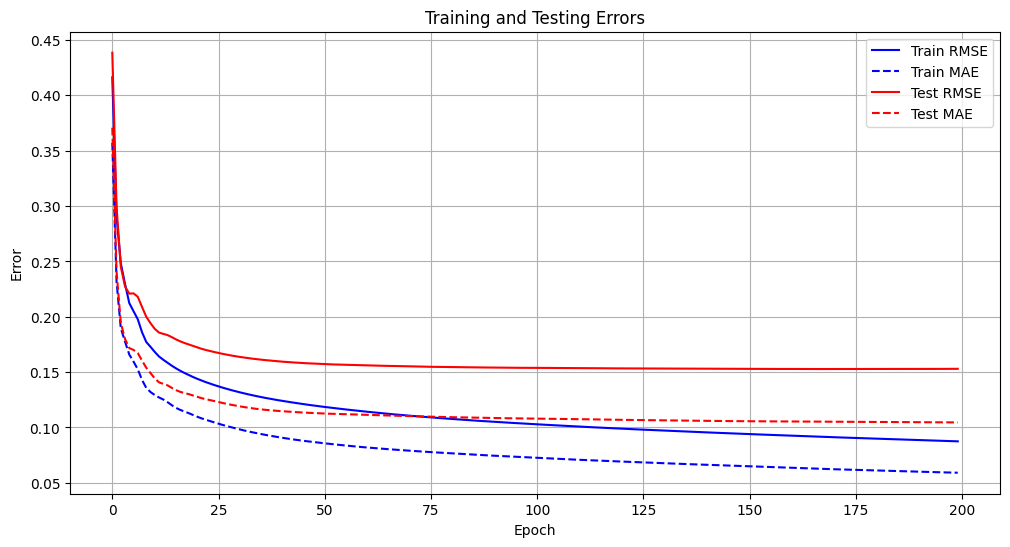

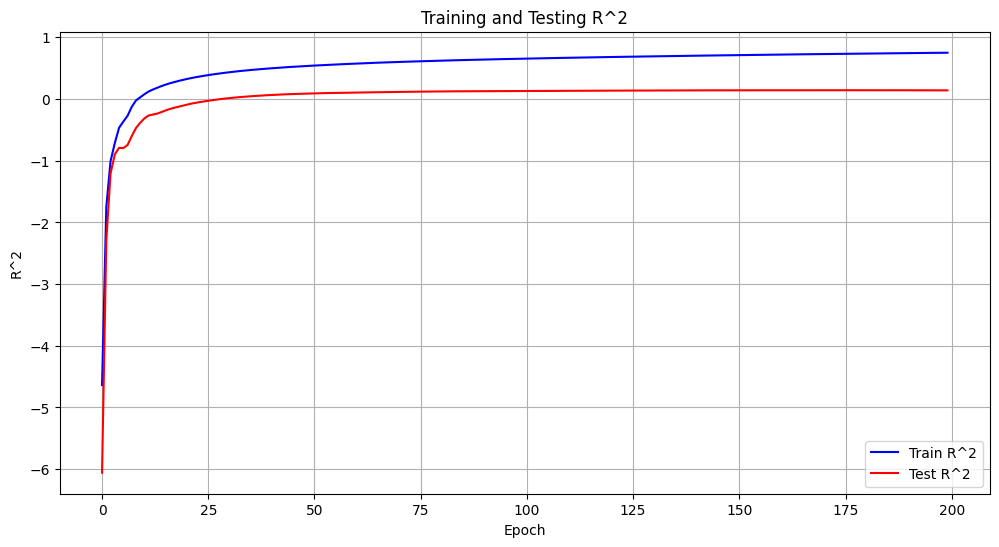

In [577]:
plotTrainingTestErrors(np.sqrt(nn_epoch_train_mse), nn_epoch_train_mae, np.sqrt(nn_epoch_test_mse), nn_epoch_test_mae)
plotTrainingTestR2(nn_epoch_r2, nn_epoch_test_r2)

Shown above are the test and train error metrics of the model as it is trained per epoch.

For the train and test RMSE and MAE, they both followed the standard graph for decreasing their error values, suggesting they trained properly. 
But it can be noted that there is a small local-minima for the test set at around the 5th epoch that the model was able to overcome.
It can also be seen that the train error metrics are significantly lower than the test ones, highlighting how the model fits more to the train set due to being trained with it.
The same trend can also be seen with the train and test R^2 scores, with the train being higher than the test.

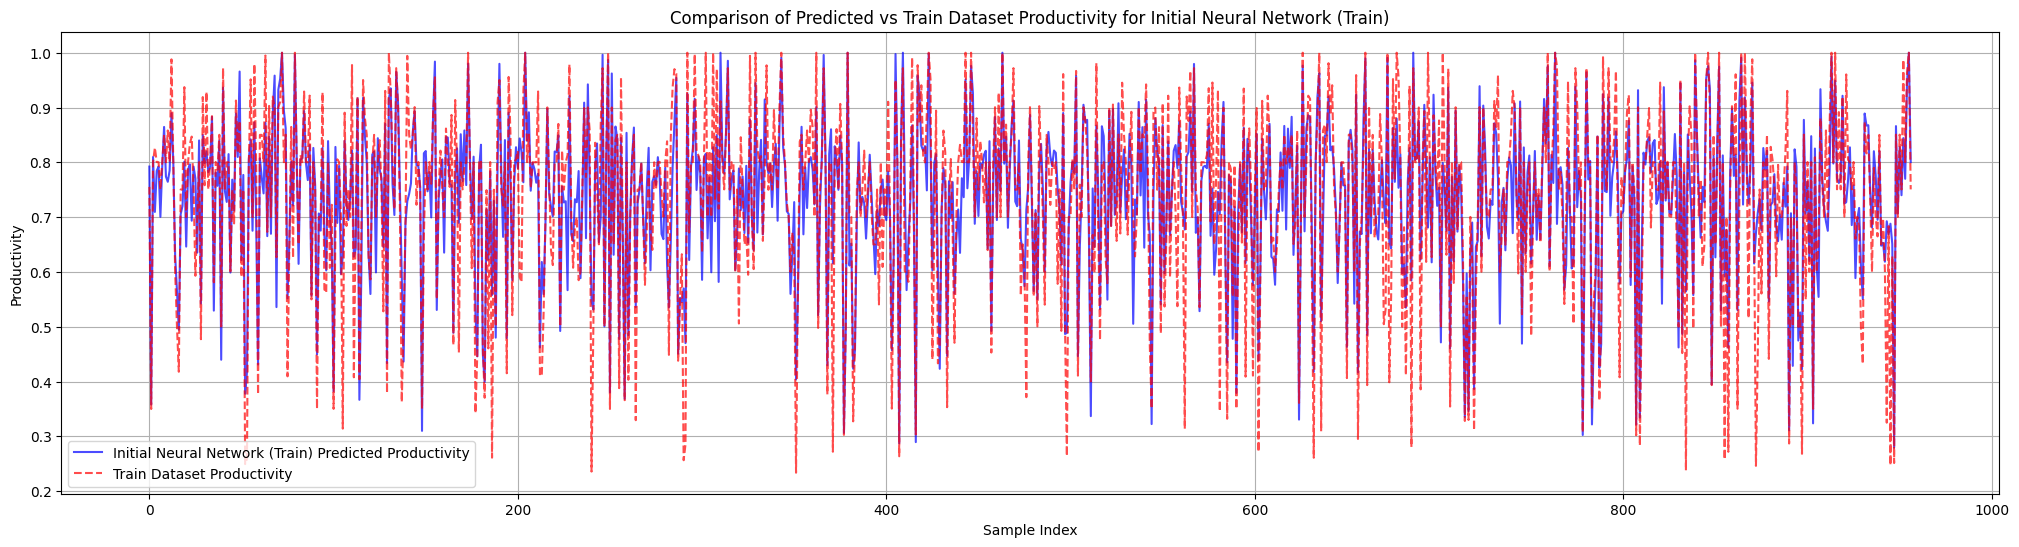

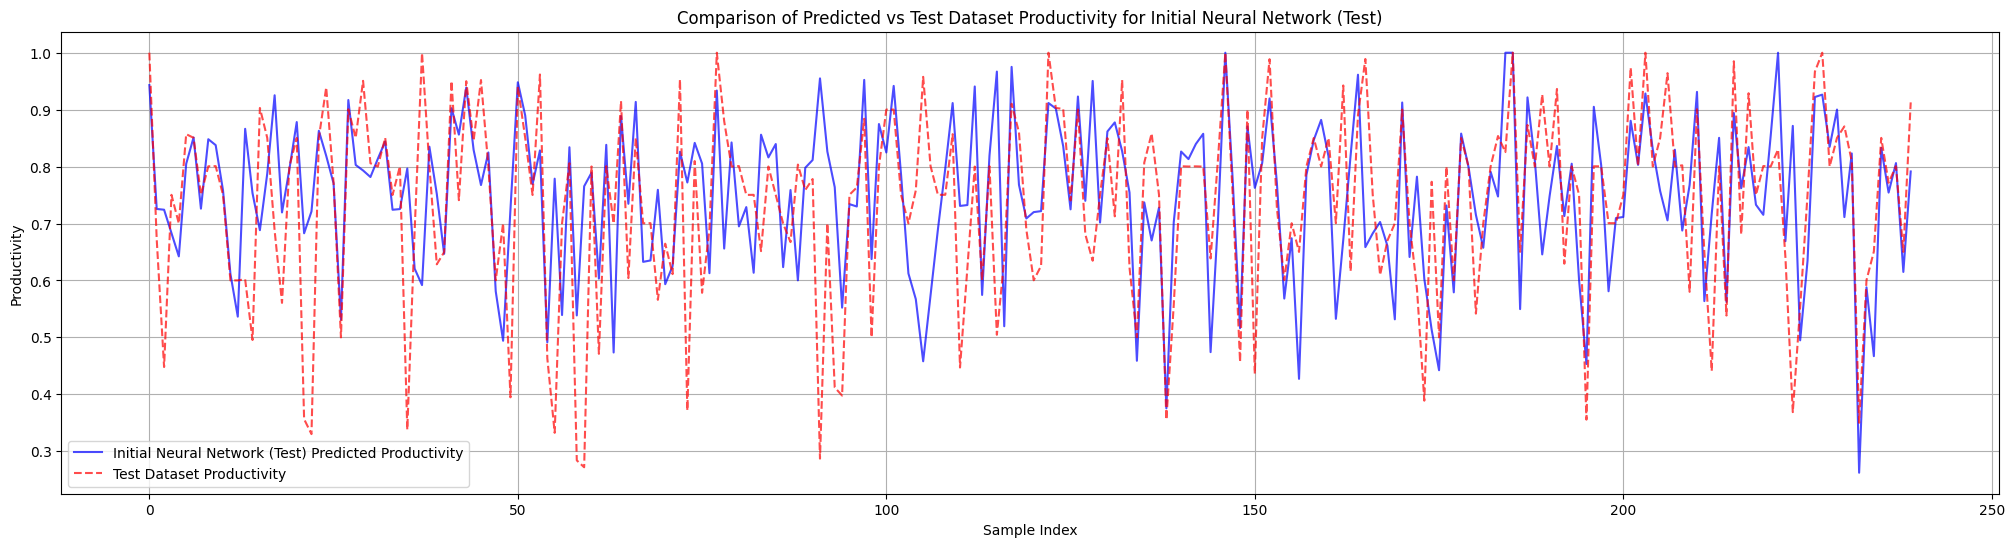

In [578]:
plotProductivityError(y_train, nn_y_train_pred, 'Initial Neural Network (Train)', False)
plotProductivityError(y_test, nn_y_test_pred, 'Initial Neural Network (Test)', True)

Shown above are the comparisons of the predicted and actual productivity values of the model to the train and test set.

Looking into the train set's graph, it can be seen how the model's predictions try its best to match those of the train set's actual productivity values. 
It was able to capture a certain trend of the data, thus matching it well in many of the points (although, it is quite hard to see).
However, it struggles to match the large variance of the higher values.

Using the model for the test set, one can see how the values don't match as well in the test set's graph.
Although it was able to follow a general trend, there were many cases where it failed to follow all the points.
Another observation was how the model's predictions tend to be more conservative as compared to the predicted values, opting to give less-varied productivity values.
Similar to the train set's graph, this makes it struggle to match the large variance of higher values; this may explain why the R^2 score was pretty low.

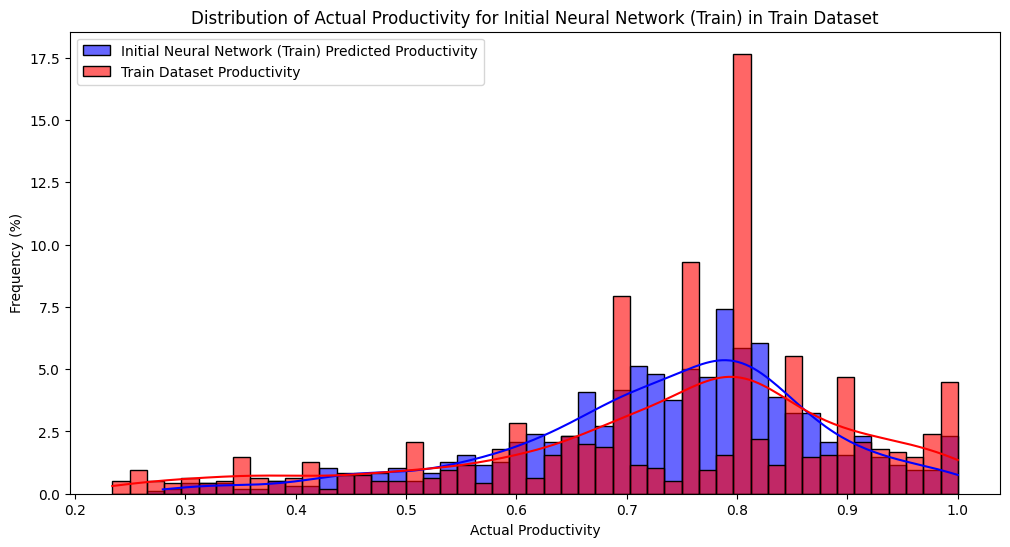

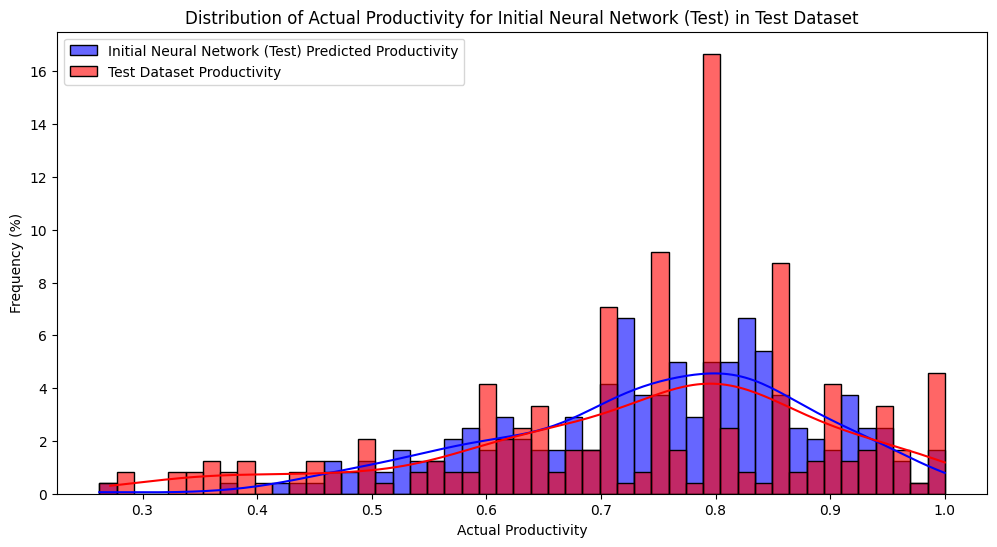

In [579]:
plotProductivityDistribution(y_train, nn_y_train_pred, 'Initial Neural Network (Train)', False)
plotProductivityDistribution(y_test, nn_y_test_pred, 'Initial Neural Network (Test)', True)

Shown above are the histograms of the predicted and actual productivity values of the model to the train and test set.
This visualizes the same data in another perspective to see more trends on the data.

Right out the bat, one can see how the data for the actual productivity have very high variance and is generally skewed to certain productivity scores.
Meanwhile, the predictions given by the model are a lot more conservative and spreads out its values.
These confirm the suspicion on the previous analysis. 

This unbalanced skew makes it difficult for the model to consistently predict the actual values of the dataset, resulting to worse error metrics, despite the trend lines in the graph being relatively similar.

# VIII. Improving Model Performance

## VIII-A. Linear Regression

## VIII-B. Random Forest

In [580]:
import sklearn.ensemble
from sklearn import metrics
#rf_regressor = sklearn.ensemble.RandomForestRegressor(n_estimators= , max_depth= , min_samples_split= , min_samples_leaf= , )
rf_regressor = sklearn.ensemble.RandomForestRegressor(random_state=random_seed)

In [581]:
rf_regressor.fit(X_train, y_train)


RandomForestRegressor(random_state=69)

In [582]:
getModelPerformance(rf_regressor, 'Initial Random Forest Model', False)

Initial Random Forest Model Train MSE: 0.0019615031499284306
Initial Random Forest Model Test MSE: 0.018514849802299428

Initial Random Forest Model Train RMSE: 0.0442888603367532
Initial Random Forest Model Test RMSE: 0.13606928309614713

Initial Random Forest Model Train MAE: 0.026943753521431527
Initial Random Forest Model Test MAE: 0.079271717871125

Initial Random Forest Model Train R^2: 0.9361814665058318
Initial Random Forest Model Test R^2: 0.32031061068997524


## VIII-C. Neural Network

After training the Initial Neural Network model and evaluating its performance, now it is time to create an improved model by using hyperparameter tuning.

As the hyperparameter tuning and training of Neural Networks takes a while to complete (40 minutes in this case), it was more economical to export and save the model for later use to prevent needing to retrain a new model every time the notebook is run.

The code below checks whether there already exists a Tuned Neural Network in the folder to use for testing and evaluation.
If there is already a saved model, it will not run the hyperparameter tuning anymore and will use the existing model.
Otherwise, it will train and tune a model, then save it into the folder.

In [583]:
# Try to load the model
tuned_nn_model = None
try:
    tuned_nn_model = joblib.load('nn_rscv.pkl')
except:
    tuned_nn_model = None

Helper function to get all a list of all possible combinations of hidden layers given the minimum layers, maximum layers, and neuron options. 

In [584]:
# Get all possible hidden layer sizes combinations
def get_hidden_layer_sizes(min_layers, max_layers, neuron_options):
    hidden_layer_sizes = []
    for num_layers in range(min_layers, max_layers + 1):
        for combination in itertools.product(neuron_options, repeat=num_layers):
            hidden_layer_sizes.append(combination)
    return hidden_layer_sizes

For the hyperparameter options, most of them were chosen with the basis being that they are the standard and most used.
This goes for the Initial Learning Rate and Regularization Constant being decimals of 1.
As for the max iterations, several standard values were included for the model to select the best number of iterations while preventing under and over fitting.

Meanwhile, as for the optimizer and activation function, they can be selected from those that are available within the MLPRegressor model.
In general, the most performant of the available options were selected, such as selecting ADAM over Stochastic Gradient Descent, TanH and ReLU over Logistic, and Adaptive over Constant learning rate change.

Lastly, the most significant of the hyperparameters is the number of hidden layers and neurons per layer. 
Although there is no definite answer for these parameters, a good starting point for simple problems is to have 1-2 hidden layers with 2/3 of the input size number for the neurons per layer (An, 2022).
However, the current problem is very intricate and complex with its values, so the simple case may not very feasible.
Additionally, as Python itself can output Memory Errors if a list is too big, certain values had to be limited for the model.
In the end, after multiple tunning iterations, it was found that 10 hidden layers with a combination of 50, 100, 250, and 500 neurons were the most performant in the hyperparameter tuning.
This was chosen to highlight the complexity of the features by adding multiple hidden layers, while also distributing neuron sizes to balance out the neurons for each layer.

Hyperparameter Tunning Options:
- Neurons and hidden layers: 10 layers with a combination of [50, 100, 250, 500] neurons
- Solver and Optimizer: ADAM
- Activation Function: [TanH, ReLU]
- Max Iterations: [200, 400, 600, 800, 1000]
- Initial Learning Rate: [0.1, 0.01, 0.001, 0.0001]
- Learning Rate Change: adaptive
- Regularization Constant: [0.00001, 0.0001, 0.001, 0.01, 0.1]
- Random Sate: 69

In [585]:
nn_hyperparameters = None

# Define hyperparameters
if tuned_nn_model is None:
    
    # Define hidden layer sizes
    neuron_options = [50, 100, 250, 500]
    min_layers = 10
    max_layers = 10
    
    nn_hyperparameters = [
        {
            'hidden_layer_sizes': get_hidden_layer_sizes(min_layers, max_layers, neuron_options),
            'solver': ['adam'],
            'activation': ['tanh', 'relu'],
            'max_iter': [200, 400, 600, 800, 1000],
            'learning_rate_init': [0.1, 0.01, 0.001, 0.0001],
            'learning_rate': ['adaptive'],
            'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1]
        }
    ]

For the actual hyperparameter tuning technique, the RandomizedSearchCV technique was used.

RandomizedSearchCV is a method for tuning the hyperparameters of a model by randomly selecting values rather than using a fixed grid of parameters, like GridSearchCV. 
In each iteration, it tests a different set of hyperparameters and records how well the model performs by using Cross-Validation to separate the train set into train and validation and evaluate them. 
After multiple iterations, it identifies the combination that yields the best results. 
This random selection approach reduces unnecessary calculations compared to testing every possible combination systematically and can generally yield similar results (GeeksforGeeks, 2023).

To tune the hyperparameters faster, the n_jobs parameter was set to -1, which means that the model will use all available CPU cores to tune the model concurrently, thus saving time.
The n_iter parameter was also set to 100. 
Although this increases training time, it gives the RandomizedSearchCV more of a chance to stumble across a more accurate combination of hyperparameters.

In [586]:
# Randomized Search to find the best hyperparameters and Train the model
if tuned_nn_model is None:
    
    tuned_nn_regressor = MLPRegressor(random_state=random_seed)
    tuned_nn_model = RandomizedSearchCV(tuned_nn_regressor, nn_hyperparameters, n_iter=100, cv=5, n_jobs=-1, random_state=random_seed)
    tuned_nn_model.fit(X_train_scaled, y_train)
    joblib.dump(tuned_nn_model, 'nn_rscv.pkl')

After the hyperparameters have been tuned and the model has been trained, display its error metrics for both train and test sets to show its performance. The analysis for the errors will be featured in the Model Performance Summary section.

In [587]:
# Get the performance of the model
getModelPerformance(tuned_nn_model, 'Tuned Neural Network', True)

Tuned Neural Network Train MSE: 0.013626707850113981
Tuned Neural Network Test MSE: 0.017993082392974084

Tuned Neural Network Train RMSE: 0.11673349069617503
Tuned Neural Network Test RMSE: 0.1341382957733327

Tuned Neural Network Train MAE: 0.0807844327510955
Tuned Neural Network Test MAE: 0.08939847596051743

Tuned Neural Network Train R^2: 0.5566479149526348
Tuned Neural Network Test R^2: 0.33946495304722035


Below are the best hyperparameters chosen after running the hyperparameter tunning.

Most Performant Hyperparameter Values:
- Neurons and hidden layers: 10 layers with [500, 250, 250, 100, 500, 500, 250, 500, 250, 50] neurons
- Solver and Optimizer: ADAM
- Activation Function: TanH
- Max Iterations: 1000
- Initial Learning Rate: 0.0001
- Learning Rate Change: adaptive
- Regularization Constant: 0.00001
- Random Sate: 69

In [588]:
# Get the best hyperparameters
tuned_nn_model.best_params_

{'max_iter': 1000,
 'learning_rate_init': 0.0001,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (500, 250, 250, 100, 500, 500, 250, 500, 250, 50),
 'alpha': 1e-05,
 'activation': 'tanh'}

# IX. Model Performance Summary

## IX-A. Linear Regression

## IX-B. Decision Trees

## IX-C. Neural Network

In [595]:
# Get the performance of the initial and tuned neural network models
getModelPerformance(initial_nn_model, 'Initial Neural Network', True)
print('\n--------------------------------------------------\n')
getModelPerformance(tuned_nn_model, 'Tuned Neural Network', True)

Initial Neural Network Train MSE: 0.00765604684632986
Initial Neural Network Test MSE: 0.023414102891207895

Initial Neural Network Train RMSE: 0.08749883911418402
Initial Neural Network Test RMSE: 0.15301667520635748

Initial Neural Network Train MAE: 0.059153600656400594
Initial Neural Network Test MAE: 0.10458704682380317

Initial Neural Network Train R^2: 0.75090650141793
Initial Neural Network Test R^2: 0.14045658132259198

--------------------------------------------------

Tuned Neural Network Train MSE: 0.013626707850113981
Tuned Neural Network Test MSE: 0.017993082392974084

Tuned Neural Network Train RMSE: 0.11673349069617503
Tuned Neural Network Test RMSE: 0.1341382957733327

Tuned Neural Network Train MAE: 0.0807844327510955
Tuned Neural Network Test MAE: 0.08939847596051743

Tuned Neural Network Train R^2: 0.5566479149526348
Tuned Neural Network Test R^2: 0.33946495304722035


Shown above are the final performance metrics of both the Initial and Tuned Neural Networks after training.

Comparing the performance of the Initial and Tuned Neural Networks, it can be noted that the Initial Model's predictions fits the train set a lot more than the Tuned Model. 
This may be because the RandomizedSearch using Cross-Validation and training the model with only a subset of the train set and using the rest for evaluation.
This lets the Tuned Model not overfit to the train set, thus why it has a higher error.

Meanwhile, for the test set, the Tuned Model performs only marginally better than the Initial Model.
This may be because the default parameters of the Initial Model are already pretty good in generating a workable model by themselves.



For the train error metrics, it is not surprising that they are very low as the model is trained with it. Meanwhile for the test error metrics, given that it only used the default parameters for the MLP Regressor, its error metrics are already very low.

As the test RMSE and MAE are around 0.1~, it suggests that the the average error of the model's predicted value is +- 0.1~ from the test set's actual_productivity value.
However, the test R^2 error is 0.14, meaning that the model's predicted values only match around 14% of all the test set's actual_productivity values.
These values mean that the average error of the model to the test set is low, but it doesn't actually fit majority of the data well as a whole.

In [590]:
nn_y_train_pred = tuned_nn_model.predict(X_train_scaled)
nn_y_test_pred = tuned_nn_model.predict(X_test_scaled)

# Scale the predicted values back to 0 and 1
nn_y_train_pred = np.clip(nn_y_train_pred, 0, 1)
nn_y_test_pred = np.clip(nn_y_test_pred, 0, 1)

In [ ]:
# Show the first 20 instances of the predicted and actual productivity for the train and test dataset
print("Predicted - Train:\n")
print(showPredToActualTable(y_train, nn_y_train_pred, 20, False))
print("\n")
print("Predicted - Test:\n")
print(showPredToActualTable(y_test, nn_y_test_pred, 20, True))

Predicted - Train:

    Predicted Productivity  Train Dataset Productivity
0                 0.710984                    0.755167
1                 0.410452                    0.349951
2                 0.856971                    0.800393
3                 0.712118                    0.826803
4                 0.846741                    0.800594
5                 0.826022                    0.800333
6                 0.738642                    0.750520
7                 0.778675                    0.800125
8                 0.893136                    0.850313
9                 0.800401                    0.800129
10                0.713668                    0.858144
11                0.790364                    0.800580
12                0.748425                    0.987880
13                0.816754                    0.800344
14                0.622481                    0.600598
15                0.533237                    0.500035
16                0.613422                   

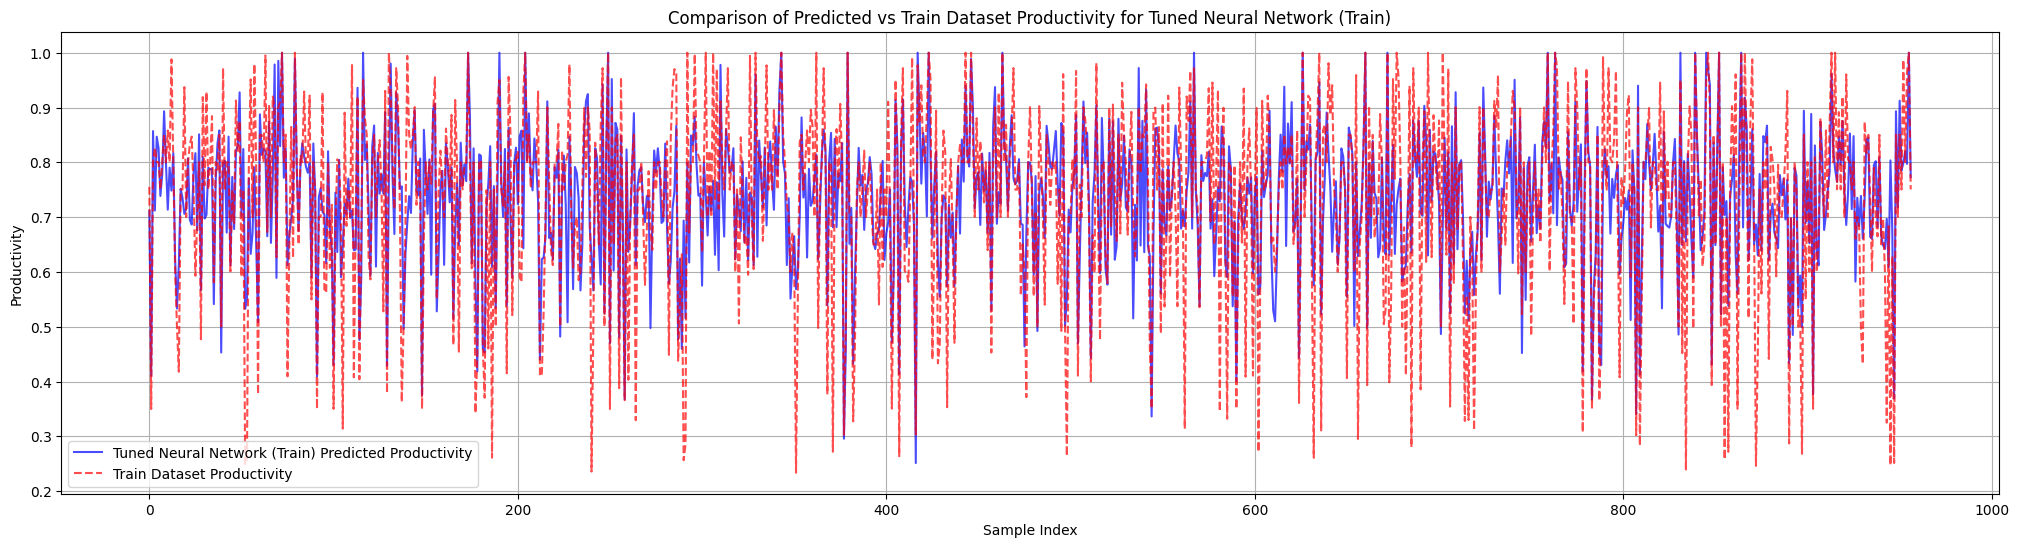

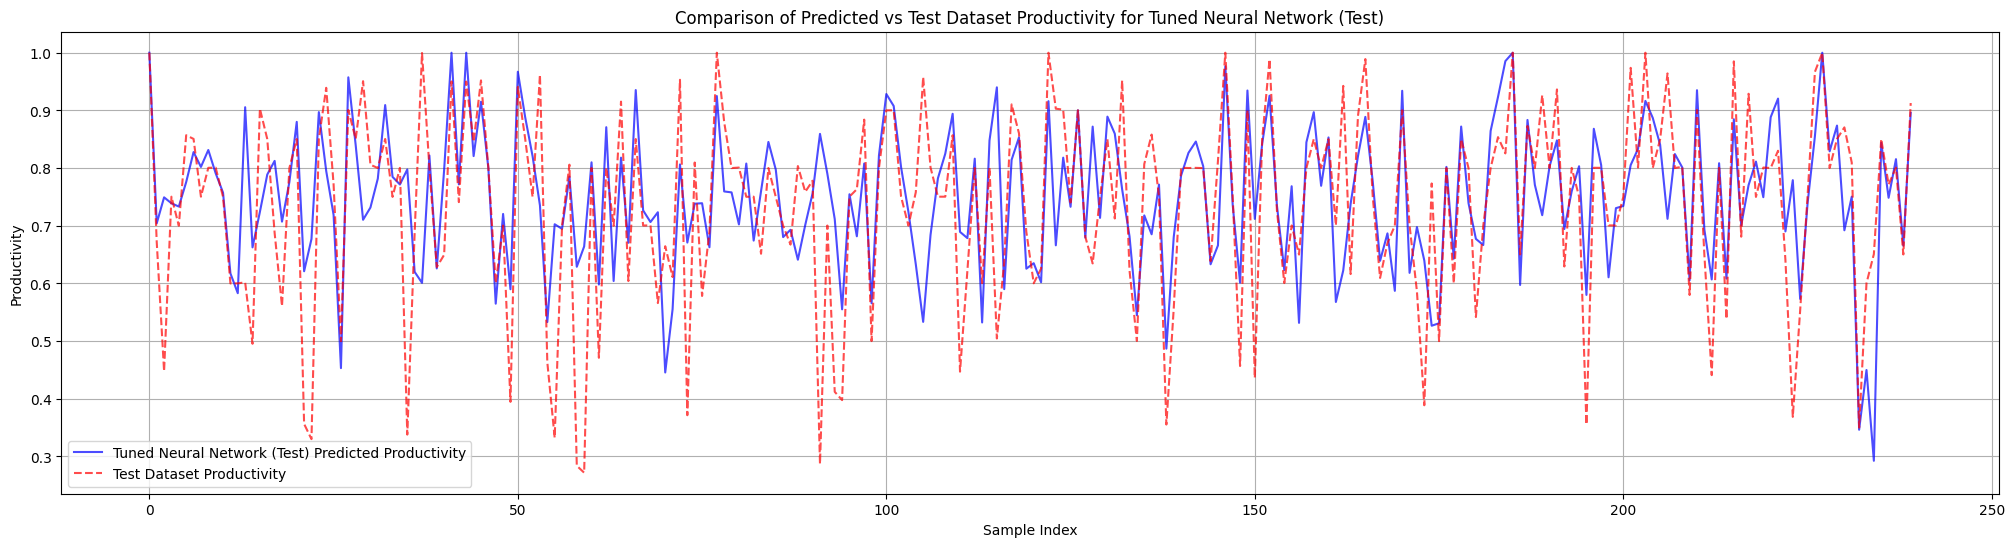

In [592]:
plotProductivityError(y_train, nn_y_train_pred, 'Tuned Neural Network (Train)', False)
plotProductivityError(y_test, nn_y_test_pred, 'Tuned Neural Network (Test)', True)

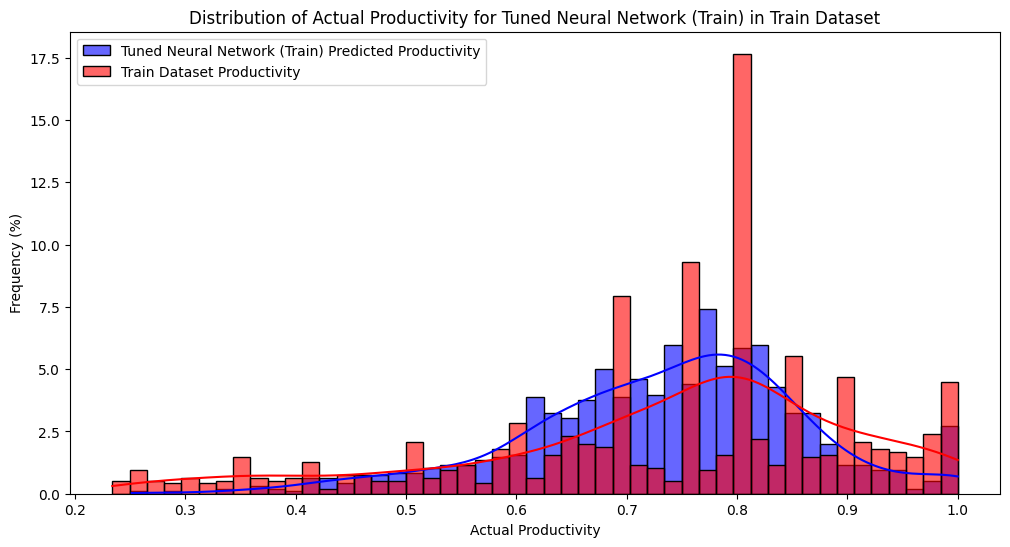

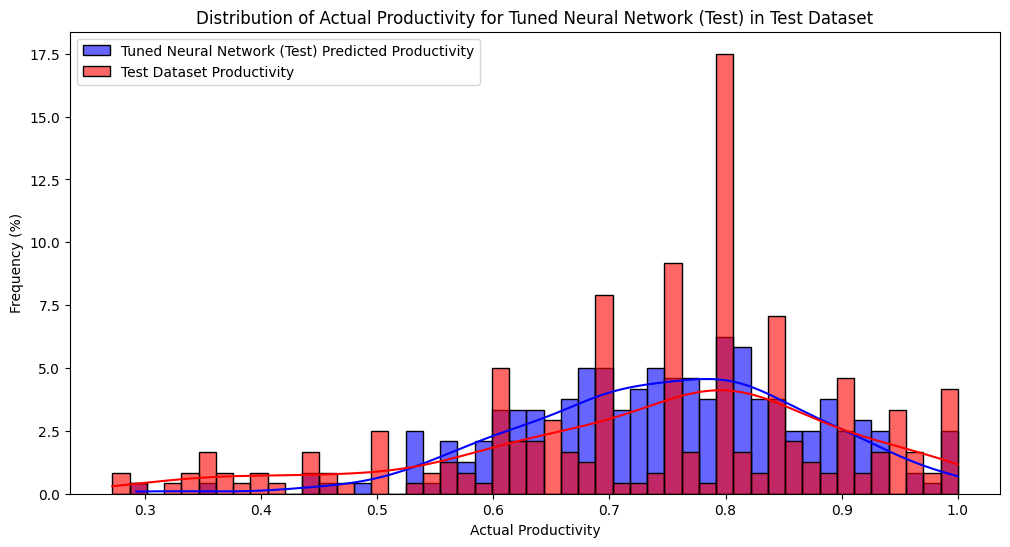

In [593]:
plotProductivityDistribution(y_train, nn_y_train_pred, 'Tuned Neural Network (Train)', False)
plotProductivityDistribution(y_test, nn_y_test_pred, 'Tuned Neural Network (Test)', True)

# X. Insights and Conclusions

# XI. References

## Neural Networks
1. 1.17. Neural network models (supervised). (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised
   - Multi-layer Perceptron (MLP) Models of scikit-learn

2. MLPRegressor. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
   - Multi-layer Perceptron (MLP) Regressor of scikit-learn

3. Karpathy, A. (2019, April 25). A recipe for training neural networks. Andrej Karpathy blog. https://karpathy.github.io/2019/04/25/recipe/
   - General tips to train Neural Networks

4. Dutta, S. (2024, November 24). Number of neurons per hidden layer in neural networks: a guide. Medium. https://medium.com/@sanjay_dutta/number-of-neurons-per-hidden-layer-in-neural-networks-a-guide-106fea04fbfe
   - Tips for number of neurons and hidden layers for Neural Networks

5. An, S. (2022, June 2). How to tune hyperparameters for better neural network performance. Medium. https://medium.com/codex/how-to-tune-hyperparameters-for-better-neural-network-performance-b8f542855d2e
   - Tips for hyperparameter tuning of Neural Networks

6. GeeksforGeeks. (2023, December 7). Hyperparameter tuning. GeeksforGeeks. https://www.geeksforgeeks.org/hyperparameter-tuning/
   - Tips for hyperparameter tuning in general